In [3]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from main import *
from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

In [2]:
### common parameters
agnetsCount = 1000
rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.005), np.arange(0.1, 1, 0.05)
])
distanceDs = np.concatenate([
    np.arange(0.1, 1, 0.05), np.arange(1, 2.1, 0.5)
])

class1, class2 = (
    np.concatenate([np.ones(500), np.zeros(500)]).astype(bool), 
    np.concatenate([np.zeros(500), np.ones(500)]).astype(bool)
)
speedV = 3

targetPath = "lastState.h5"  # lastStateAfter  # lastStateRing  # lastState

totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")

modelNums = totalPositionX.shape[0] // agnetsCount

totalPositionX = totalPositionX.values.reshape(modelNums, agnetsCount, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(modelNums, agnetsCount)
totalPointTheta = totalPointTheta.values.reshape(modelNums, agnetsCount)

idx = 0
positionX = dict()
phaseTheta = dict()
pointTheta = dict()

np.random.seed(10)
omegaTheta = np.concatenate([
    np.random.uniform(1, 3, size=500),
    np.random.uniform(-3, -1, size=500)
])

for l, d0 in product(rangeLambdas, distanceDs):
    
    positionX[f"{l:.3f}_{d0:.2f}"] = totalPositionX[idx]
    phaseTheta[f"{l:.3f}_{d0:.2f}"] = totalPhaseTheta[idx]
    pointTheta[f"{l:.3f}_{d0:.2f}"] = totalPointTheta[idx]

    idx += 1

def plot_last_state(key: str, ax: plt.Axes = None, loadModel: bool = False,
                    showTicks: bool = False, tickSize: int = 16, randomSeed: int = 10):
    if ax is None:

        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    if loadModel:
        l, d0 = key.split("_")
        l, d0 = float(l), float(d0)
        model = SpatialGroups(l, d0, speedV, savePath="./data", randomSeed=randomSeed)
        sa = StateAnalysis(model, showTqdm=False)
        singlePositionX, singlePhaseTheta, _ = sa.get_state(-1)
    else:
        singlePositionX = positionX[key]
        singlePhaseTheta = phaseTheta[key]
    alphaRate = 0.9
    np.random.seed(10)
    omegaTheta = np.concatenate([
        np.random.uniform(1, 3, size=500),
        np.random.uniform(-3, -1, size=500)
    ])
    scale = 35
    width = 0.003
    ax.quiver(
        singlePositionX[class1, 0], singlePositionX[class1, 1],
        np.cos(singlePhaseTheta[class1]), np.sin(singlePhaseTheta[class1]), color='red', 
        alpha = (1 - alphaRate) + (np.abs(omegaTheta[class1]) - 1) / 2 * alphaRate,
        scale=scale, width=width
    )
    ax.quiver(
        singlePositionX[class2, 0], singlePositionX[class2, 1],
        np.cos(singlePhaseTheta[class2]), np.sin(singlePhaseTheta[class2]), color='#414CC7', 
        alpha = (1 - alphaRate) + (np.abs(omegaTheta[class2]) - 1) / 2 * alphaRate,
        scale=scale, width=width
    )

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    if showTicks:
        ax.set_xticks([0, 10])
        ax.set_yticks([0, 10])
        ax.set_xlabel(r"$x$", fontsize=tickSize)
        ax.set_ylabel(r"$y$", fontsize=tickSize, rotation=0)
        ax.set_xticklabels(ax.get_xticks(), fontsize=tickSize)
        ax.set_yticklabels(ax.get_yticks(), fontsize=tickSize)
        # 拉近label与坐标轴的距离
        ax.xaxis.labelpad = -20
        ax.yaxis.labelpad = -10
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    ax.grid(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    # ax.text(0.3, 9.2, "A", fontsize=20)
    # ax.text(9.2, 9.2, "B", fontsize=20)
    # ax.text(9.2, 0.3, "C", fontsize=20)
    # ax.text(0.3, 0.3, "D", fontsize=20)
    plt.tick_params(direction='in', length=3)

def plot_centers(self: StateAnalysis, ax: plt.Axes = None, index: int = -1):
    positionX, phaseTheta, pointTheta = self.get_state(index)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    quiverColors = ["#FF4B4E"] * 500 + ["#414CC7"] * 500
    ax.quiver(
        positionX[:, 0], positionX[:, 1],
        np.cos(phaseTheta[:]), np.sin(phaseTheta[:]), color=quiverColors, alpha=1
    )
    centerColors = ["#FBDD85"] * 500 + ["#80A6E2"] * 500
    centers = self.centers
    ax.scatter(centers[:, 0], centers[:, 1], color=centerColors, s=5)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)    
    fontsize = 20
    ax.xaxis.labelpad = -20
    ax.yaxis.labelpad = -10
    ax.set_xticks([0, 10])
    ax.set_yticks([0, 10])
    ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticks(), fontsize=fontsize)
    ax.grid(False)
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.tick_params(direction='in', length=3)
    ax.set_xlabel(r"$x$", fontsize=fontsize)
    ax.set_ylabel(r"$y$", fontsize=fontsize, rotation=0)

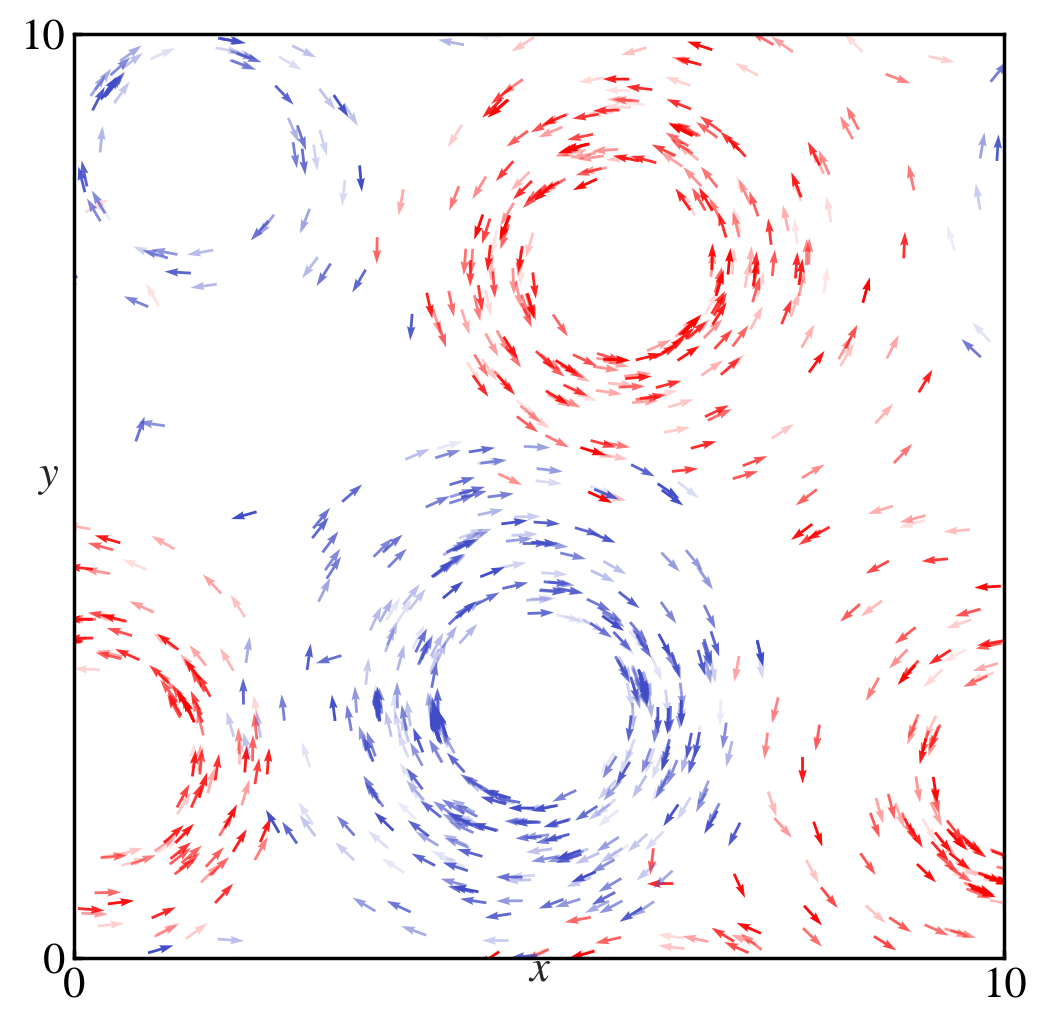

In [172]:
# plot single graphy
l, d0 = 0.08, 0.15
key = f"{l:.3f}_{d0:.2f}"
plot_last_state(key, showTicks=True)

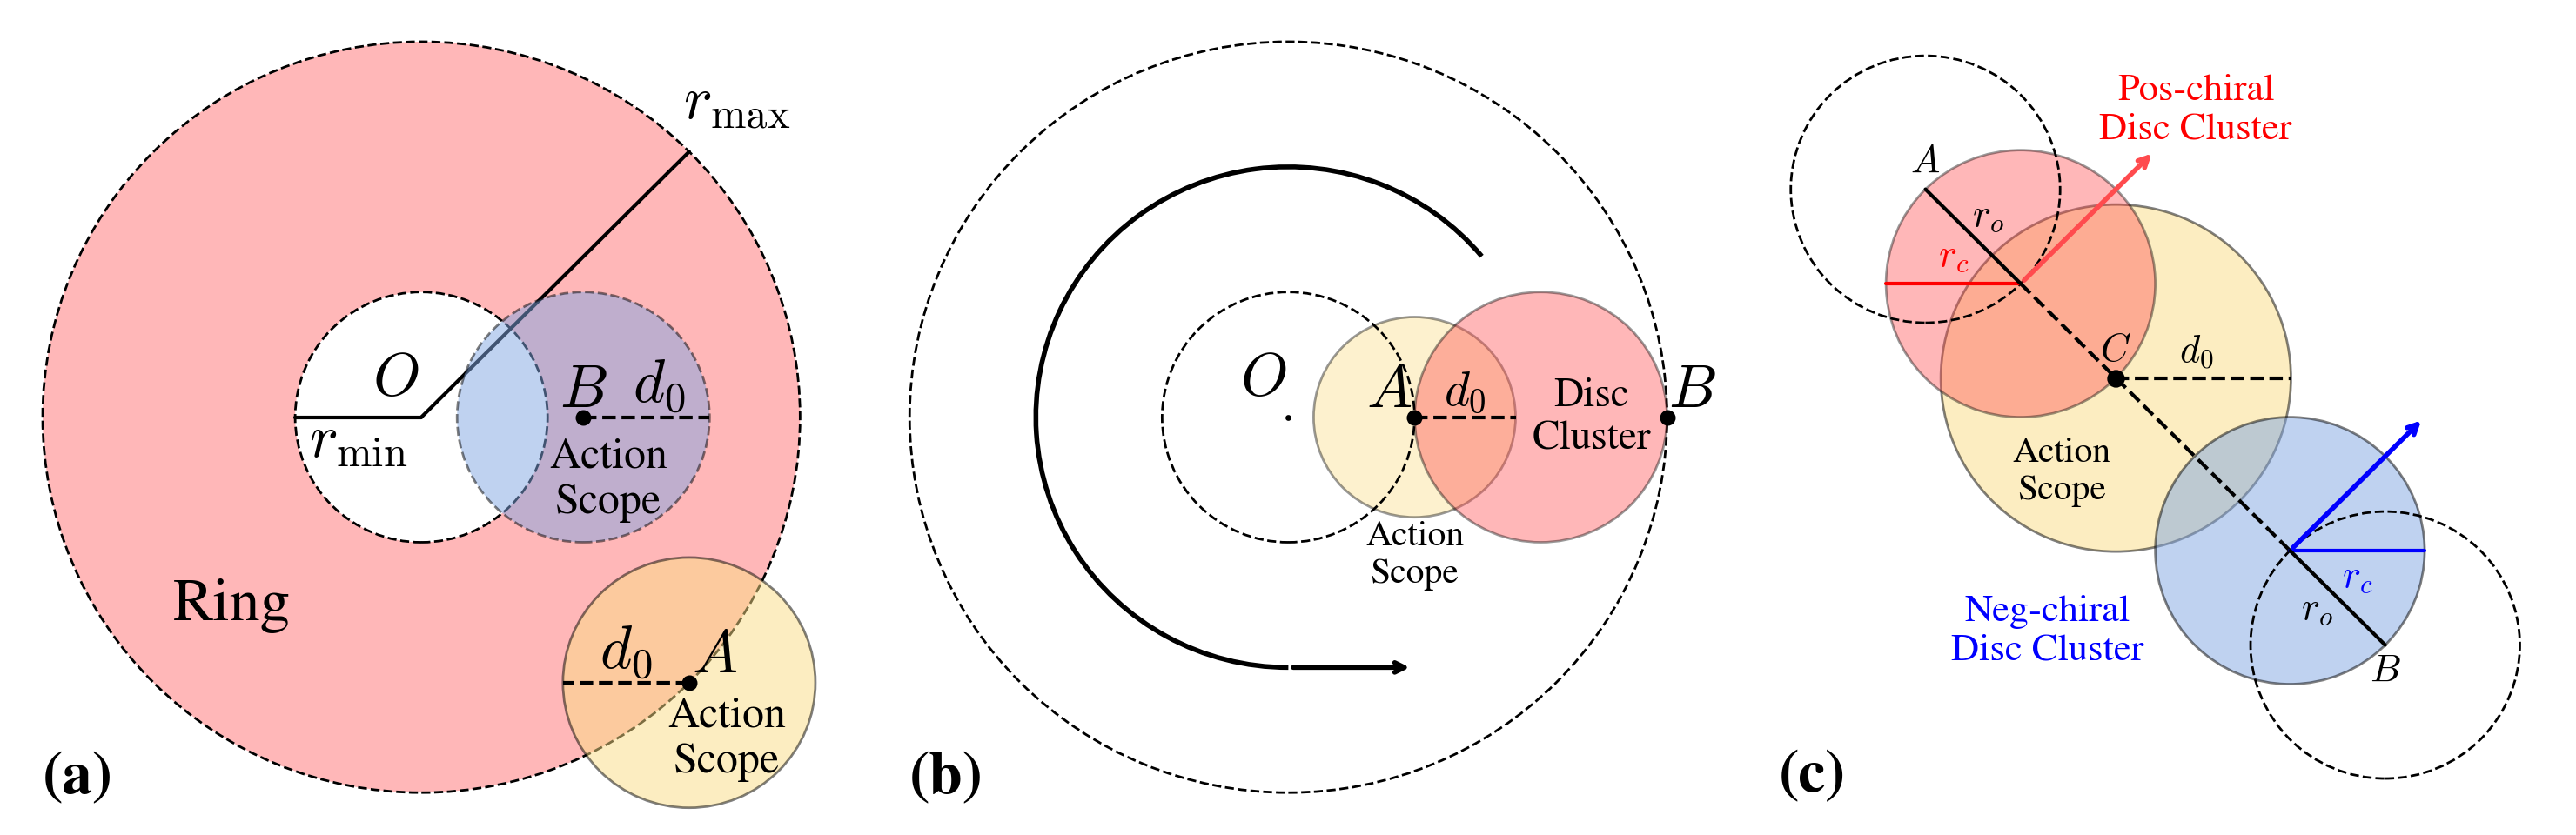

In [31]:
sns.set_theme(
    # style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
circle1 = plt.Circle((5, 5), 3, facecolor="#FF4B4E", edgecolor="white", 
                     fill=True, linestyle="--", zorder=1, alpha=0.4)
circle11 = plt.Circle((5, 5), 3, facecolor="#FF4B4E", edgecolor="black", 
                      fill=False, linestyle="--", zorder=1, alpha=1)
# --------------------------------
circleLambda2 = plt.Circle((6.2828, 5), 1, facecolor='#80A6E2', edgecolor="black", 
                           fill=True, linestyle="--", alpha=0.5, zorder=10)
ax1.add_artist(circleLambda2)
ax1.scatter([6.2828], [5], color="black", s=30, zorder=10)
ax1.plot([6.2828, 7.2828], [5] * 2, color='black', linestyle="--", zorder=100)
ax1.text(6.2828, 5.2, r"$B$", ha="center", va="center", fontsize=25, zorder=100)
ax1.text(6.8828, 5.25, r"$d_0$", ha="center", va="center", fontsize=25, zorder=100)
ax1.text(6.4828, 4.5, "Action\nScope", ha="center", va="center", fontsize=18, zorder=20)
# --------------------------------
ax1.add_artist(circle1)
ax1.add_artist(circle11)
ax1.plot([5, 5 + 3 / np.sqrt(2)], [5, 5 + 3 / np.sqrt(2)], color='black', linestyle="-")
ax1.text(7.5, 7.5, r"$r_{\max}$", ha="center", va="center", fontsize=25)
ax1.add_artist(plt.Circle((5, 5), 1, facecolor='white', edgecolor="black", fill=True, linestyle="--"))
ax1.plot([5, 5 - 1], [5, 5], color='black', linestyle="-")
ax1.text(4.5, 4.8, r"$r_{\min}$", ha="center", va="center", fontsize=25)
ax1.text(4.8, 5.3, r"$O$", ha="center", va="center", fontsize=25)
ax1.text(5.2 + 3/np.sqrt(2), 5.2 - 3/np.sqrt(2), r"$A$", ha="center", va="center", fontsize=25)
ax1.scatter([5 + 3/np.sqrt(2)], [5 - 3/np.sqrt(2)], color="black", s=30, zorder=10)
circle2 = plt.Circle((5 + 3/np.sqrt(2), 5 - 3/np.sqrt(2)), 1, edgecolor="black",
                     facecolor='#FBDD85', fill=True, linestyle="-", alpha=0.5, zorder=1)
ax1.plot([5 + 3/np.sqrt(2), 5 + 3/np.sqrt(2)-1], [5 - 3/np.sqrt(2)] * 2, color='black', linestyle="--")
ax1.text(5 + 3/np.sqrt(2)-0.5, 5 - 3/np.sqrt(2) + 0.25, r"$d_0$", ha="center", va="center", fontsize=25)
ax1.text(5 + 3/np.sqrt(2) + 0.3, 5 - 3/np.sqrt(2) - 0.45, "Action\nScope", 
         ha="center", va="center", fontsize=18, zorder=10)
ax1.text(3.5, 3.5, "Ring", ha="center", va="center", fontsize=25, zorder=10)

ax1.add_artist(circle2)
ax1.set_xlim(1.8, 8.2)
ax1.set_ylim(1.8, 8.2)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.text(2, 2, "(a)", fontweight="bold", fontsize=25)

ax2 = plt.subplot(1, 3, 2)
ax2.add_artist(plt.Circle((5, 5), 3, color='black', fill=False, linestyle="--"))
ax2.add_artist(plt.Circle((5, 5), 1, color='black', fill=False, linestyle="--"))
ax2.add_artist(plt.Circle((7, 5), 1, edgecolor="black", facecolor="#FF4B4E", alpha=0.4, fill=True))
ax2.text(5.8, 5.2, r"$A$", ha="center", va="center", fontsize=25)
ax2.scatter([6], [5], color="black", s=30)
ax2.text(8.2, 5.2, r"$B$", ha="center", va="center", fontsize=25)
ax2.scatter([8], [5], color="black", s=30)
ax2.text(7.4, 5, "Disc\nCluster", ha="center", va="center", fontsize=17)
ax2.text(4.8, 5.3, r"$O$", ha="center", va="center", fontsize=25)
ax2.scatter([5], [5], color="black", s=2)
end = 270
ax2.add_patch(patches.Arc((5, 5), 4, 4, 0, 40, end, linewidth=2, color='black'))
ax2.add_patch(patches.FancyArrowPatch(
    (5 + 2 * np.cos(np.deg2rad(end)), 5 + 2 * np.sin(np.deg2rad(end))), 
    (5 + 2 * np.cos(np.deg2rad(end)) - 1 * np.cos(np.deg2rad(end - 90)), 
     5 + 2 * np.sin(np.deg2rad(end)) - 1 * np.sin(np.deg2rad(end - 90))),
    arrowstyle='->', mutation_scale=10, color='black', linewidth=2, 
))
ax2.add_artist(plt.Circle((6, 5), 0.8, edgecolor="black", facecolor="#FBDD85", alpha=0.4, fill=True, zorder=0))
ax2.text(6, 3.9, "Action\nScope", ha="center", va="center", fontsize=15, zorder=10)
ax2.plot([6, 6.8], [5, 5], color='black', linestyle="--")
ax2.text(6.4, 5.2, r"$d_0$", ha="center", va="center", fontsize=20)
ax2.set_xlim(1.8, 8.2)
ax2.set_ylim(1.8, 8.2)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.text(2, 2, "(b)", fontweight="bold", fontsize=25)

ax3 = plt.subplot(1, 3, 3)
ax3.add_artist(plt.Circle((1, 2), 0.5, edgecolor="black", facecolor="#FF4B4E", alpha=0.4, fill=True))
ax3.plot([0.5, 1], [2, 2], color='red', linestyle="-")
ax3.text(0.75, 2.1, r"$r_c$", ha="center", va="center", fontsize=16, color="red")
ax3.plot([1 - 0.5 / np.sqrt(2), 1], [2 + 0.5 / np.sqrt(2), 2], color='black', linestyle="-")
ax3.add_artist(plt.Circle((1 - 0.5 / np.sqrt(2), 2 + 0.5 / np.sqrt(2)), 
                         0.5, edgecolor="black", alpha=1, fill=False, linestyle="--"))
ax3.text(1 - 0.5 / np.sqrt(2), 2.1 + 0.5 / np.sqrt(2), r"$A$", ha="center", va="center", fontsize=16, color="black")
ax3.add_patch(patches.FancyArrowPatch(
    (1, 2), (1.5, 2.5),
    arrowstyle='->', mutation_scale=10, color='#FF4B4E', linewidth=2, 
))
ax3.plot([1, 2], [2, 1], color='black', linestyle="--")
ax3.add_artist(plt.Circle((1 + 0.5 / np.sqrt(2), 2 - 0.5 / np.sqrt(2)), 0.65, zorder=0,
                          edgecolor="black", facecolor="#FBDD85", alpha=0.5, fill=True))
ax3.plot([1 + 0.5 / np.sqrt(2), 1 + 0.5 / np.sqrt(2) + 0.65], 
        [2 - 0.5 / np.sqrt(2), 2 - 0.5 / np.sqrt(2)],
        color="black", linestyle="--")
ax3.text(1 + 0.5 / np.sqrt(2) + 0.3, 2.1 - 0.5 / np.sqrt(2), r"$d_0$", 
         ha="center", va="center", fontsize=16, color="black")
ax3.text(1.65, 2.65, "Pos-chiral\nDisc Cluster", ha="center", va="center", fontsize=16, color="red")
ax3.text(1 + 0.5 / np.sqrt(2), 2.1 - 0.5 / np.sqrt(2), r"$C$", ha="center", va="center", fontsize=16, color="black")
ax3.text(0.8 + 0.5 / np.sqrt(2), 1.65 - 0.5 / np.sqrt(2), "Action\nScope", ha="center", va="center", fontsize=15, zorder=10)
ax3.scatter([1 + 0.5 / np.sqrt(2)], [2 - 0.5 / np.sqrt(2)], color="black", s=40, zorder=10)

ax3.add_artist(plt.Circle((2, 1), 0.5, edgecolor="black", facecolor="#80A6E2", alpha=0.5, fill=True))
ax3.plot([2, 2.5], [1, 1], color="blue", linestyle="-")
ax3.text(2.25, 0.9, r"$r_c$", ha="center", va="center", fontsize=16, color="blue")
ax3.text(1.1, 0.7, "Neg-chiral\nDisc Cluster", ha="center", va="center", fontsize=16, color="blue")
ax3.plot([2 + 0.5 / np.sqrt(2), 2], [1 - 0.5 / np.sqrt(2), 1], color='black', linestyle="-")
ax3.add_artist(plt.Circle((2 + 0.5 / np.sqrt(2), 1 - 0.5 / np.sqrt(2)), 
                         0.5, edgecolor="black", alpha=1, fill=False, linestyle="--"))
ax3.text(2 + 0.5 / np.sqrt(2), 0.9 - 0.5 / np.sqrt(2), r"$B$", ha="center", va="center", fontsize=16, color="black")
ax3.add_patch(patches.FancyArrowPatch(
    (2, 1), (2.5, 1.5),
    arrowstyle='->', mutation_scale=10, color='blue', linewidth=2, 
))
ax3.text(0.88, 2.25, r"$r_o$", ha="center", va="center", fontsize=16)
ax3.text(2.10, 0.78, r"$r_o$", ha="center", va="center", fontsize=16)
plt.xlim(0, 3)
plt.ylim(0, 3)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.text(0.1, 0.1, "(c)", fontweight="bold", fontsize=25)

plt.tight_layout()
# folderPath = "./PJT_C_Fig"
folderPath = "../../c-doc/[PJT_C] Chiral2/figs"
plt.savefig(f"{folderPath}/analyticalEps.pdf", bbox_inches="tight", dpi=300)

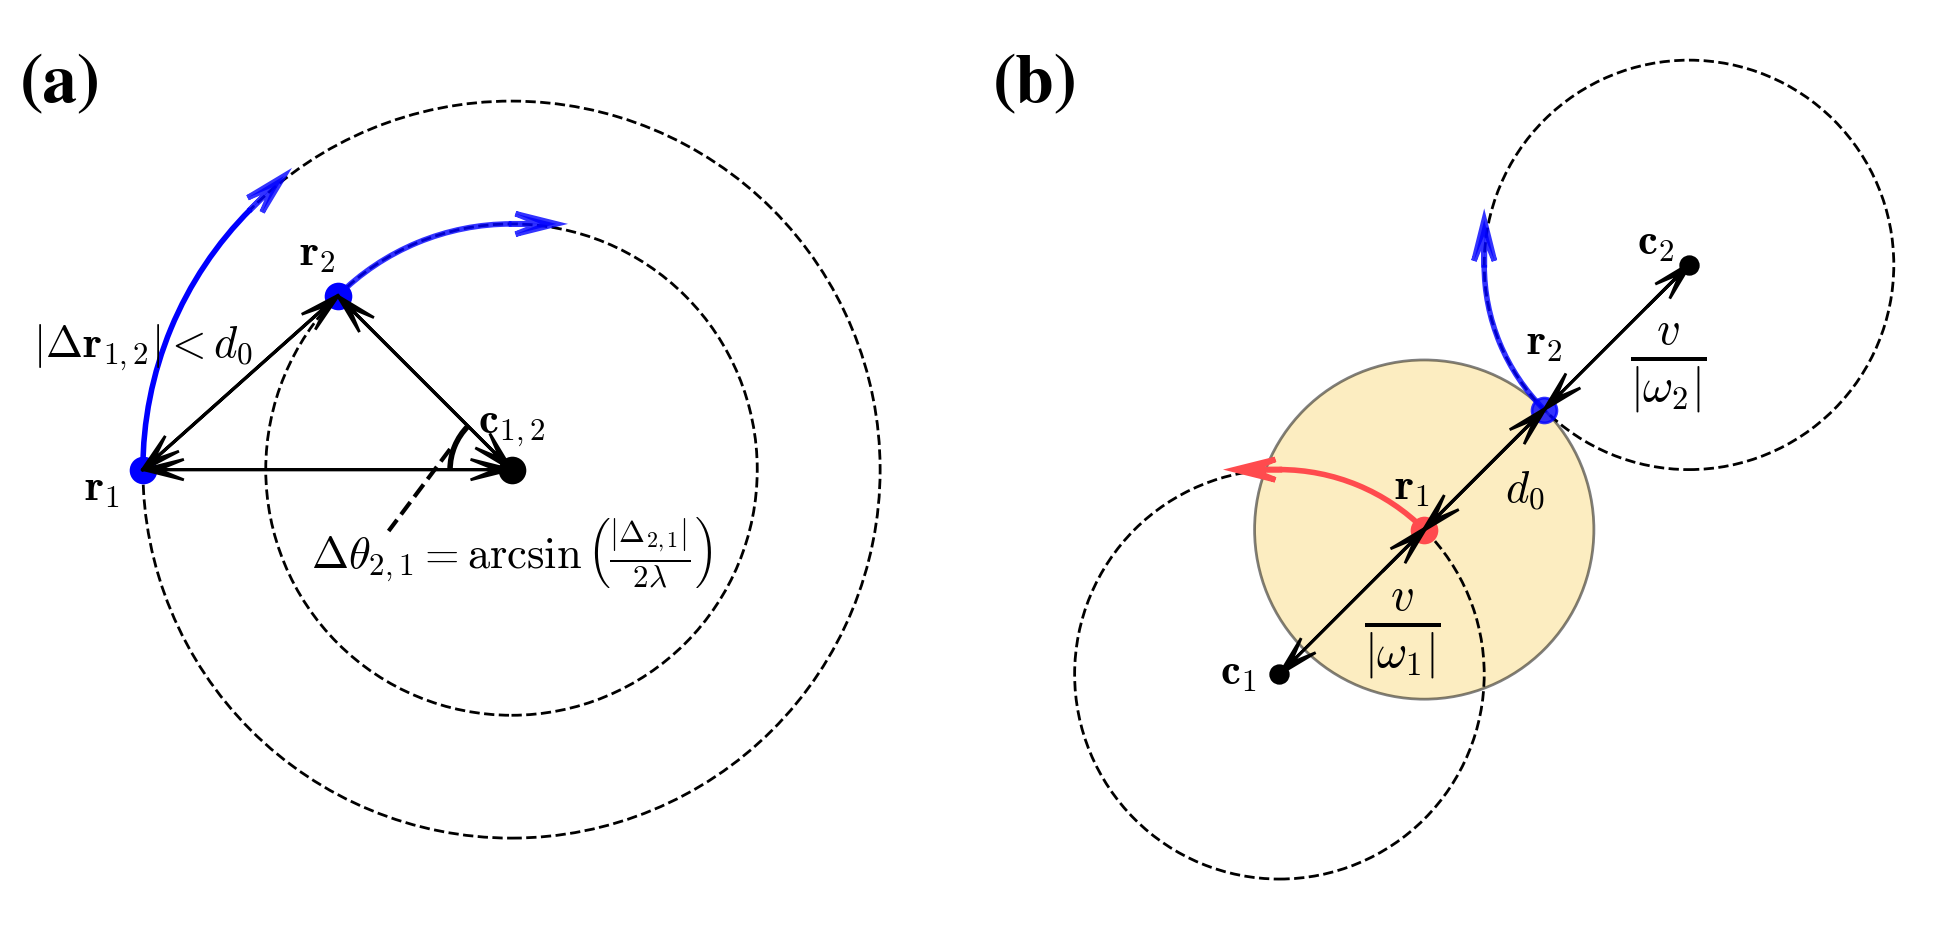

In [72]:
sns.set_theme(
    # style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(10, 4.9))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.add_artist(plt.Circle((1.5, 1.5), 0.9, edgecolor="black", 
               alpha=1, fill=False, linestyle="--"))
ax1.add_artist(plt.Circle((1.5, 1.5), 0.6, edgecolor="black", 
               alpha=1, fill=False, linestyle="--"))
ax1.scatter([1.5], [1.5], color="black", s=80)
ax1.scatter([1.5 - 0.9, 1.5 - 0.6 / np.sqrt(2)], 
            [1.5, 1.5 + 0.6 / np.sqrt(2)], color="blue", s=80)
ax1.add_patch(patches.Arc((1.5, 1.5), 1.2, 1.2, 0, 90, 135, 
              linewidth=2, color="blue", alpha=0.8, lw=2))
ax1.add_patch(patches.Arc((1.5, 1.5), 1.8, 1.8, 0, 135, 180, 
              linewidth=2, color="blue"))
ax1.add_patch(patches.Arc((1.5, 1.5), 0.3, 0.3, 0, 135, 180, 
              linewidth=2, color="black"))
ax1.arrow(1.5, 2.1, 0.01, 0, head_length=0.1, head_width=0.05, lw=2,
          color='blue', linestyle="-", alpha=0.8, zorder=10, overhang=0.6)
ax1.arrow(1.5 - 0.9 / np.sqrt(2), 1.5 + 0.9 / np.sqrt(2), 
          0.01, 0.01, head_length=0.1, head_width=0.05, lw=2,
          color='blue', linestyle="-", alpha=0.8, zorder=10, overhang=0.6)
ax1.arrow(1.5, 1.5, - 0.5 / np.sqrt(2), 0.5 / np.sqrt(2), head_length=0.1, head_width=0.05,
          color='black', linestyle="-", alpha=1, zorder=10, overhang=0.6)
ax1.arrow(1.5 - 0.6 / np.sqrt(2), 1.5 + 0.6 / np.sqrt(2), 0.5 / np.sqrt(2), -0.5 / np.sqrt(2), head_length=0.1, head_width=0.05,
          color='black', linestyle="-", alpha=1, zorder=10, overhang=0.6)
ax1.arrow(1.5, 1.5, -0.8, 0, head_length=0.1, head_width=0.05, 
          color='black', linestyle="-", alpha=1, zorder=10, overhang=0.6)
ax1.arrow(1.5 - 0.9, 1.5, 0.8, 0, head_length=0.1, head_width=0.05,
          color='black', linestyle="-", alpha=1, zorder=10, overhang=0.6)
ax1.arrow(1.5 - 0.6 / np.sqrt(2), 1.5 + 0.6 / np.sqrt(2), 
          (0.6 / np.sqrt(2) - 0.9) * 0.85, -0.6 / np.sqrt(2) * 0.85, 
          head_length=0.1, head_width=0.05, color='black', 
          linestyle="-", alpha=1, zorder=10, overhang=0.6)
ax1.arrow(1.5 - 0.9, 1.5,
          -(0.6 / np.sqrt(2) - 0.9) * 0.85, 0.6 / np.sqrt(2) * 0.85, head_length=0.1, head_width=0.05, color='black', 
          linestyle="-", alpha=1, zorder=10, overhang=0.6)
ax1.text(1.5, 1.6, r"$\mathbf{c}_{1,2}$", ha="center", va="center", 
         fontsize=16, color="black")
ax1.text(1.5 - 1, 1.5 - 0.05, r"$\mathbf{r}_1$", ha="center", va="center",
         fontsize=16, color="black")
ax1.text(1.4 - 0.6 / np.sqrt(2) + 0.05, 1.65 + 0.6 / np.sqrt(2) - 0.05,
            r"$\mathbf{r}_2$", ha="center", va="center", fontsize=16, color="black")
ax1.text(0.6, 1.8, r"$|\Delta\mathbf{r}_{1,2}|<d_0$", ha="center", va="center", fontsize=16, color="black")
ax1.text(1.5, 1.3, r"$\Delta \theta _{2,1}=\arcsin \left( \frac{\left| \Delta _{2,1} \right|}{2\lambda} \right)$", ha="center", va="center", fontsize=16, color="black")
ax1.plot([1.35, 1.2], [1.55, 1.35], color='black', linestyle="--")

ax1.text(0.3, 2.4, "(a)", fontweight="bold", fontsize=25)
ax1.set_xlim(0.4, 2.6)
ax1.set_ylim(0.4, 2.6)
ax1.set_xticks([])
ax1.set_yticks([])

ax2.add_artist(plt.Circle((2, 2), 0.5, edgecolor="black", alpha=1, fill=False, linestyle="--"))
ax2.add_artist(plt.Circle((1, 1), 0.5, edgecolor="black", alpha=1, fill=False, linestyle="--"))
ax2.add_patch(patches.Arc((2, 2), 1, 1, 0, 180, 225, linewidth=2, color="blue", alpha=0.8, lw=2))
ax2.add_patch(patches.Arc((1, 1), 1, 1, 0, 45, 90, linewidth=2, color="#FF4B4E"))
ax2.arrow(1.5, 2, 0, 0.01, head_length=0.1, head_width=0.05, lw=2,
          color='blue', linestyle="-", alpha=0.8, zorder=10, overhang=0.6)
ax2.arrow(1, 1.5, -0.01, 0, head_length=0.1, head_width=0.05, lw=2,
          color='#FF4B4E', linestyle="-", alpha=1, zorder=10, overhang=0.6)
ax2.scatter([1 + 0.5 / np.sqrt(2)], [1 + 0.5 / np.sqrt(2)], color="#FF4B4E", s=80, zorder=10)
ax2.scatter([2 - 0.5 / np.sqrt(2)], [2 - 0.5 / np.sqrt(2)], color="blue", s=80, zorder=10, alpha=0.8)
ax2.scatter([1, 2], [1, 2], color="black", s=40)
ax2.arrow(2, 2, - 0.4 / np.sqrt(2), - 0.4 / np.sqrt(2), head_length=0.1, head_width=0.05, 
          color='black', linestyle="-", alpha=1, zorder=10, overhang=0.6)
ax2.arrow(1.9, 1.9, 0.05 / np.sqrt(2), 0.05 / np.sqrt(2), head_length=0.1, head_width=0.05, 
          color='black', linestyle="-", alpha=1, zorder=10, overhang=0.6)
ax2.arrow(1 + 0.5 / np.sqrt(2), 1 + 0.5 / np.sqrt(2), - 0.4 / np.sqrt(2), - 0.4 / np.sqrt(2), head_length=0.1, head_width=0.05, 
          color='black', linestyle="-", alpha=1, zorder=10, overhang=0.6)
ax2.arrow(0.9 + 0.5 / np.sqrt(2), 0.9 + 0.5 / np.sqrt(2), 0.05 / np.sqrt(2), 0.05 / np.sqrt(2), head_length=0.1, head_width=0.05, 
          color='black', linestyle="-", alpha=1, zorder=10, overhang=0.6)

ax2.arrow(2 - 0.5 / np.sqrt(2), 2 - 0.5 / np.sqrt(2), -0.32 / np.sqrt(2), -0.32 / np.sqrt(2), head_length=0.1, head_width=0.05, 
          color='black', linestyle="-", alpha=1, zorder=10, overhang=0.6)
ax2.arrow(1 + 0.5 / np.sqrt(2), 1 + 0.5 / np.sqrt(2), 0.32 / np.sqrt(2), 0.32 / np.sqrt(2), head_length=0.1, head_width=0.05, 
          color='black', linestyle="-", alpha=1, zorder=10, overhang=0.6)
ax2.add_artist(plt.Circle(
    (1 + 0.5 / np.sqrt(2), 1 + 0.5 / np.sqrt(2)), np.sqrt(2) - 1, 
    edgecolor="black", alpha=0.5, facecolor="#FBDD85", linestyle="-", zorder=0))
ax2.text(1.6, 1.45, r"$d_0$", ha="center", va="center", fontsize=16, color="black")
ax2.text(1.3, 1.1, r"$\frac{v}{|\omega_1|}$", ha="center", va="center", fontsize=24, color="black")
ax2.text(1.95, 1.75, r"$\frac{v}{|\omega_2|}$", ha="center", va="center", fontsize=24, color="black")
ax2.text(0.9, 1, r"$\mathbf{c}_1$", ha="center", va="center", fontsize=16, color="black")
ax2.text(1.92, 2.05, r"$\mathbf{c}_2$", ha="center", va="center", fontsize=16, color="black")
ax2.text(1 + 0.5 / np.sqrt(2) - 0.03, 1 + 0.5 / np.sqrt(2) + 0.1,
         r"$\mathbf{r}_1$", ha="center", va="center", fontsize=16, color="black")
ax2.text(2 - 0.5 / np.sqrt(2), 2 - 0.5 / np.sqrt(2) + 0.16,
         r"$\mathbf{r}_2$", ha="center", va="center", fontsize=16, color="black")
ax2.text(0.3, 2.4, "(b)", fontweight="bold", fontsize=25)
ax2.set_xlim(0.4, 2.6)
ax2.set_ylim(0.4, 2.6)
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
# folderPath = "./PJT_C_Fig"
folderPath = "../../c-doc/[PJT_C] Chiral2/figs"
plt.savefig(f"{folderPath}/analyticalEps2.pdf", bbox_inches="tight", dpi=300)

### Plot Big Graph

In [ ]:
fig = plt.figure(figsize=(len(distanceDs) * 5, len(rangeLambdas) * 5))

idx = 1

for l, d0 in tqdm(product(rangeLambdas, distanceDs), total=len(rangeLambdas) * len(distanceDs)):
    
    key = f"{l:.3f}_{d0:.2f}"

    singlePositionX = positionX[key]
    singlePhaseTheta = phaseTheta[key]
    singlePointTheta = pointTheta[key]

    # centers = StateAnalysis._calc_centers(singlePositionX, singlePhaseTheta, singlePointTheta, speedV)

    ax = plt.subplot(len(rangeLambdas), len(distanceDs), idx)
    ax.quiver(
        singlePositionX[class1, 0], singlePositionX[class1, 1],
        np.cos(singlePhaseTheta[class1]), np.sin(singlePhaseTheta[class1]), color='red', alpha=0.8
    )
    ax.quiver(
        singlePositionX[class2, 0], singlePositionX[class2, 1],
        np.cos(singlePhaseTheta[class2]), np.sin(singlePhaseTheta[class2]), color='blue', alpha=0.8
    )
    # ax.scatter(centers[class1, 0], centers[class1, 1], color="orange", s=5)
    # ax.scatter(centers[class2, 0], centers[class2, 1], color="blue", s=5)
    # ax.scatter(centers[:, 0], centers[:, 1], color="green", s=3, alpha=0.7)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)    
    ax.set_title(key)

    idx += 1

plt.tight_layout()
plt.savefig("bigGraph.png", dpi=200, bbox_inches="tight")
plt.close()

In [69]:
modelForSim = SingleDistribution(
    strengthLambda=0.02, distanceD0=0.4, boundaryLength=10, 
    agentsNum=20000,
)
radius = 3 / np.abs(modelForSim.omegaTheta)
positionAngle = modelForSim.phaseTheta + np.pi / 2
positionAngle[:modelForSim.agentsNum // 2] = modelForSim.phaseTheta[:modelForSim.agentsNum // 2] - np.pi / 2

modelForSim.positionX[0] = modelForSim.positionX[1]
modelForSim.positionX[:, 0] = radius * np.cos(positionAngle) + 5
modelForSim.positionX[:, 1] = radius * np.sin(positionAngle) + 5

def get_bar_omega_prob(d0: float):
    oscPos = modelForSim.positionX
    angles = np.linspace(0, 2 * np.pi, 100)
    centerPoses = 1.2828 * np.array([np.cos(angles), np.sin(angles)]).T + 5
    probs = []
    barOmegas = []
    for centerPos in centerPoses:
        withinD0 = np.linalg.norm(oscPos - centerPos, axis=1) < d0
        withinOscOmega = modelForSim.omegaTheta[withinD0]
        barOmega = withinOscOmega.mean()
        hist, bin_edges = np.histogram(withinOscOmega, bins=1, density=True)
        prob = hist * np.diff(bin_edges)
        prob = prob[np.abs(bin_edges[:-1] - barOmega).argmin()]
        probs.append(prob)
        barOmegas.append(barOmega)
    probs = np.array(probs)
    barOmegas = np.array(barOmegas)
    return probs.mean(), barOmegas.mean()

(1.2828282828282829, 2.338582677165354)

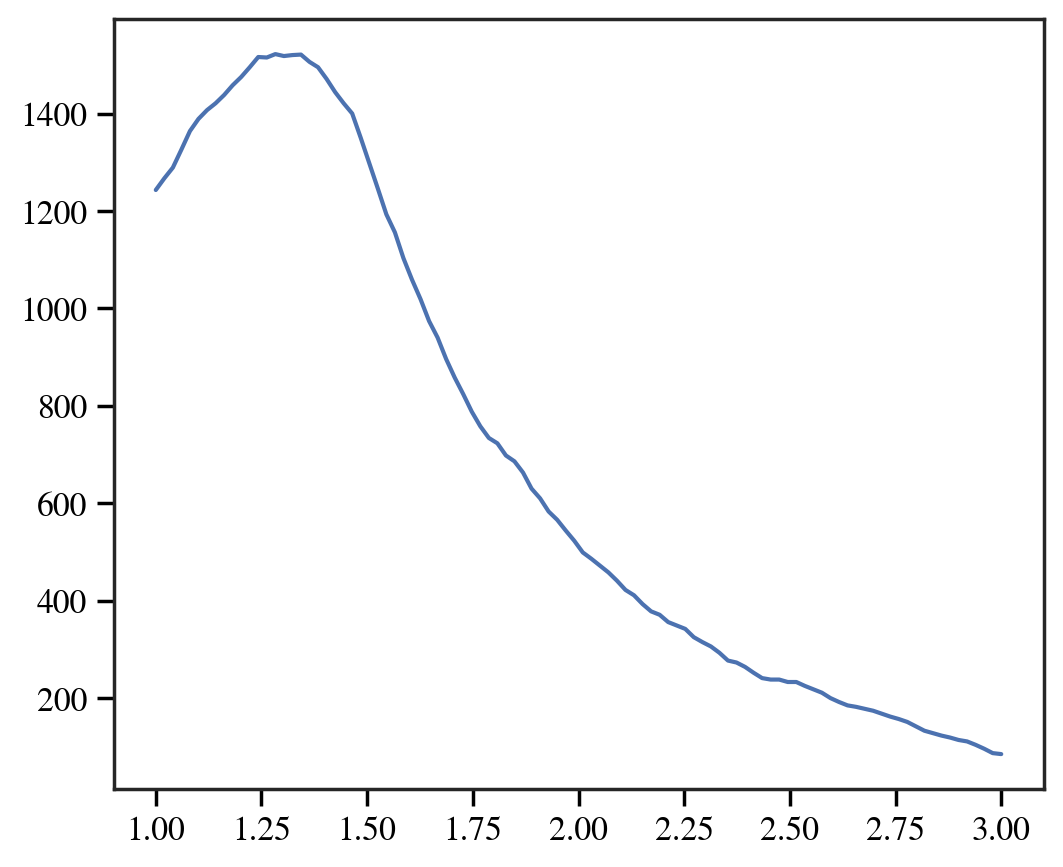

In [ ]:
oscPos = modelForSim.positionX
radii = np.linspace(1, 3, 100)
d0 = 0.5
withinOscNum = []
for radius in radii:
    centerPos = np.array([5 + radius, 5])
    withinD0 = np.linalg.norm(oscPos - centerPos, axis=1) < d0
    withinOscNum.append(np.sum(withinD0))
plt.plot(radii, withinOscNum)
maxNumRadius = radii[np.argmax(withinOscNum)]
maxNumRadius, 3 / maxNumRadius

# 序参量

In [1]:
maps = pd.read_excel("maps.xlsx", index_col=0)

globalRd = 1.2828

def lambda_c0(d0):
    rs = 1
    rd = globalRd
    if d0 + 1 < rd:
        si = 0
    else:
        beta = 2 * np.arccos((d0 ** 2 + rd ** 2 - rs ** 2) / (2 * d0 * rd))
        alpha = 2 * np.arccos((rd ** 2 + rs ** 2 - d0 ** 2) / (2 * rd * rs))
        si = alpha * rs ** 2 / 2 + beta * d0 ** 2 / 2 - d0 * rd * np.sin(beta / 2)
    Nc = 500
    deltaOmega = max(
        3 / (globalRd - 0.1) - 3 / globalRd, 
        np.abs(3 / (globalRd + 0.1) - 3 / globalRd)
    )

    NonR = Nc / 2 * (rd + d0 - 1)
    Sr1 = np.pi * ((rd + d0)**2 - 1**2)
    rho1 = NonR / Sr1
    sigmaA1 = (np.pi * d0 ** 2 - si) * rho1

    return 1 / sigmaA1 * deltaOmega

def lambda_c1(d0):
    rs = 3
    Nc = 1000 / 4
    Sr = np.pi * (3**2 - 1**2)
    deltaOmega = 2 / Nc
    beta = 2 * np.arccos(1 - d0 ** 2 / (2 * rs ** 2))
    alpha = np.pi - beta / 2
    S1 = d0**2 * alpha / 2 + rs**2 * beta / 2 - rs * d0 * np.sin(alpha / 2)
    sigmaA = S1 * Nc / Sr
    return deltaOmega / sigmaA

def lambda_c2(d0):
    rs = 1
    deltaOmega = 1
    beta = 2 * np.arccos(1 - d0 ** 2 / (2 * rs ** 2))
    alpha = np.pi - beta / 2
    N = 500 / 2
    return (
        np.pi * rs ** 2 * deltaOmega
        / (N - 1)
        / (alpha * d0**2 / 2 + beta * rs**2 / 2 - rs * d0 * np.sin(alpha / 2))
    )

def lambda_c3(d0):
    L = 10
    deltaOmega = 1
    N = 500
    rho = N / L ** 2
    sigmaA = np.pi * d0 ** 2 * rho
    return deltaOmega / sigmaA

def lambda_c4(d0):
    L = 10
    rc = 1.5
    rs = 1.5
    if d0 + 2 * (rc + rs) < L / np.sqrt(2):
        # print(d0 + 2 * (rc + rs), L / np.sqrt(2))
        return np.inf
    deltaOmega = 4
    N = 500
    rh = L / np.sqrt(2) - 2 * (rc + rs)
    rd = rh + rs
    beta = 2 * np.arccos((d0 ** 2 + rd ** 2 - rs ** 2) / (2 * d0 * rd))
    alpha = 2 * np.arccos((rd ** 2 + rs ** 2 - d0 ** 2) / (2 * rd * rs))
    si = alpha * rs ** 2 / 2 + beta * d0 ** 2 / 2 - d0 * rd * np.sin(beta / 2)
    Ni = N * si / (np.pi * rs ** 2)
    return deltaOmega / Ni

def lambda_c5(d0):
    rs = 3
    N = 1000 / 10
    rho = N / (np.pi * (3**2 - 1**2))
    deltaOmega = 2 / N
    beta = 2 * np.arccos(1 - d0 ** 2 / (2 * rs ** 2))
    alpha = np.pi - beta / 2
    Si = d0**2 * alpha / 2 + rs**2 * beta / 2 - rs * d0 * np.sin(alpha / 2)
    sigmaA = Si * rho
    return deltaOmega / sigmaA

funcIdxs = dict()
for func in [lambda_c0, lambda_c1, lambda_c2, lambda_c3, lambda_c4, lambda_c5]:
    funcIdxs[func] = []
    for d0 in maps.columns:
        l = func(d0)
        idx = 0
        upper = maps.index[maps.index > l].min()
        if np.isnan(upper):
            upper = maps.index.max()
        idx = idx + np.where(maps.index == upper)[0][0]
        lower = maps.index[maps.index < l].max()
        if np.isnan(lower):
            lower = maps.index.min()
        idx = idx + np.where(maps.index == lower)[0][0]
        funcIdxs[func].append(idx / 2)

line0 = pd.Series(funcIdxs[lambda_c0]).rolling(window=2, min_periods=1, center=True).mean().values

NameError: name 'pd' is not defined

In [3]:
maps4 = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in tqdm(product(rangeLambdas, distanceDs), total=len(rangeLambdas) * len(distanceDs)):
    
    model = SpatialGroups(strengthLambda=l, distanceD0=d0, savePath="./data")
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]
    # centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV, model.dt)
    centers = lastPositionX
    classes = StateAnalysis._calc_classes(
        centers, 0.4, 
        StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
    )
    counts = 0
    ratios = 0

    for classOcsis in classes:
        if len(classOcsis) < 2:
            continue
        counts += 1
        ratios += len(classOcsis) / model.agentsNum

    maps4.loc[l, d0] = ratios / counts

  0%|          | 0/756 [00:00<?, ?it/s]

Text(17.5, 17, 'IV')

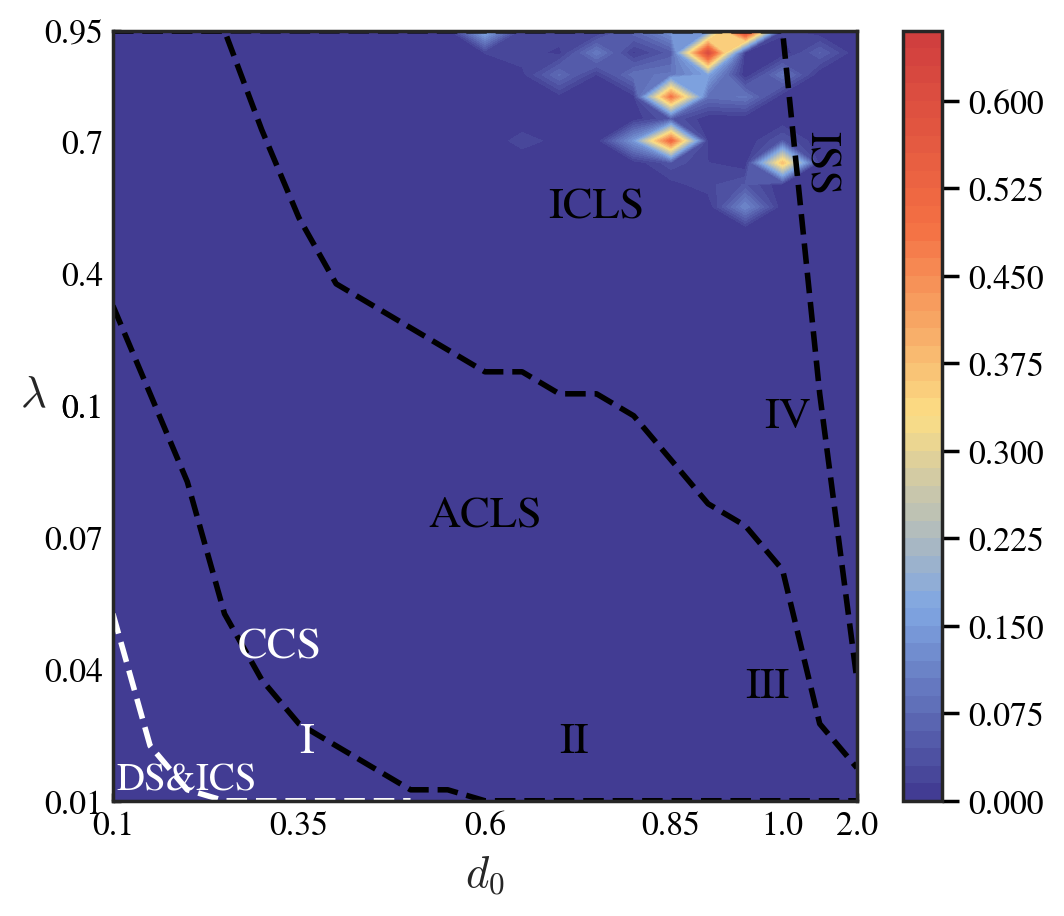

In [8]:
cf = plt.contourf(
    maps4, levels=50, 
    cmap=cmap, 
)
cbar3 = plt.colorbar(cf)

plt.tick_params(direction='in', length=3)
xIdxs = np.arange(len(distanceDs), step=5)
xIdxs = np.insert(xIdxs, -1, 18)
yIdxs = np.concatenate([np.arange(19, step=6), 18 + np.arange(18, step=6)[1:], [35]])
idx = np.where(rangeLambdas == 0.1)[0][0]
yIdxs = np.insert(yIdxs, 4, idx)
plt.xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
plt.yticks(yIdxs, np.round(rangeLambdas, 2)[yIdxs])
plt.xlabel(r"$d_0$", fontsize=16)
plt.ylabel(r"$\lambda$", rotation=0, fontsize=16)
selectedColors = ["white", "black", "black"]
i = 0
plt.plot(funcIdxs[lambda_c1][:9],
            linestyle="--", color=selectedColors[i], lw=2, zorder = 2)
# plt.plot(np.arange(maps.shape[1]), funcIdxs[lambda_c2], label=r"$\lambda_{c2}(d_0)$",
#             linestyle="--", color="black", lw=2, zorder = 2)
plt.plot(np.arange(maps.shape[1]), funcIdxs[lambda_c3], label=r"$\lambda_{c3}(d_0)$",
        linestyle="--", color="black", lw=2, zorder = 2)
plt.plot(np.arange(maps.shape[1]), funcIdxs[lambda_c4], label=r"$\lambda_{c4}(d_0)$",
        linestyle="--", color="black", lw=2, zorder = 2)
plt.plot(np.arange(maps.shape[1]), funcIdxs[lambda_c5], label=r"$\lambda_{c4}(d_0)$",
        linestyle="--", color="black", lw=2, zorder = 2)
# ax[i].text(0, -4, "Disorder State", fontsize=16, color="black", rotation=0)

plt.text(0.1, 0.5, "DS&ICS", fontsize=14, color=selectedColors[i])
plt.text(4.5, 7, "CCS", ha="center", va="center", fontsize=16, color=selectedColors[i])
plt.text(10, 13, "ACLS", ha="center", va="center", fontsize=16, color="black")
plt.text(13, 27, "ICLS", ha="center", va="center", fontsize=16, color="black")
plt.text(18.5, 28, "ISS", fontsize=16, color="Black", rotation=-90)
plt.text(5, 2.2, "I", fontsize=16, color=selectedColors[i])
plt.text(12, 2.2, "II", fontsize=16, color="black")
plt.text(17, 4.7, "III", fontsize=16, color="black")
plt.text(17.5, 17, "IV", fontsize=16, color="black")

In [4]:
maps4 = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in tqdm(product(rangeLambdas, distanceDs), total=len(rangeLambdas) * len(distanceDs)):
    
    model = SpatialGroups(strengthLambda=l, distanceD0=d0, savePath="./data")
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]
    deltaOmega = np.mean(
        (lastPointTheta - lastPointTheta[:, np.newaxis]) ** 2
    )

    maps4.loc[l, d0] = deltaOmega

  0%|          | 0/756 [00:00<?, ?it/s]

d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator


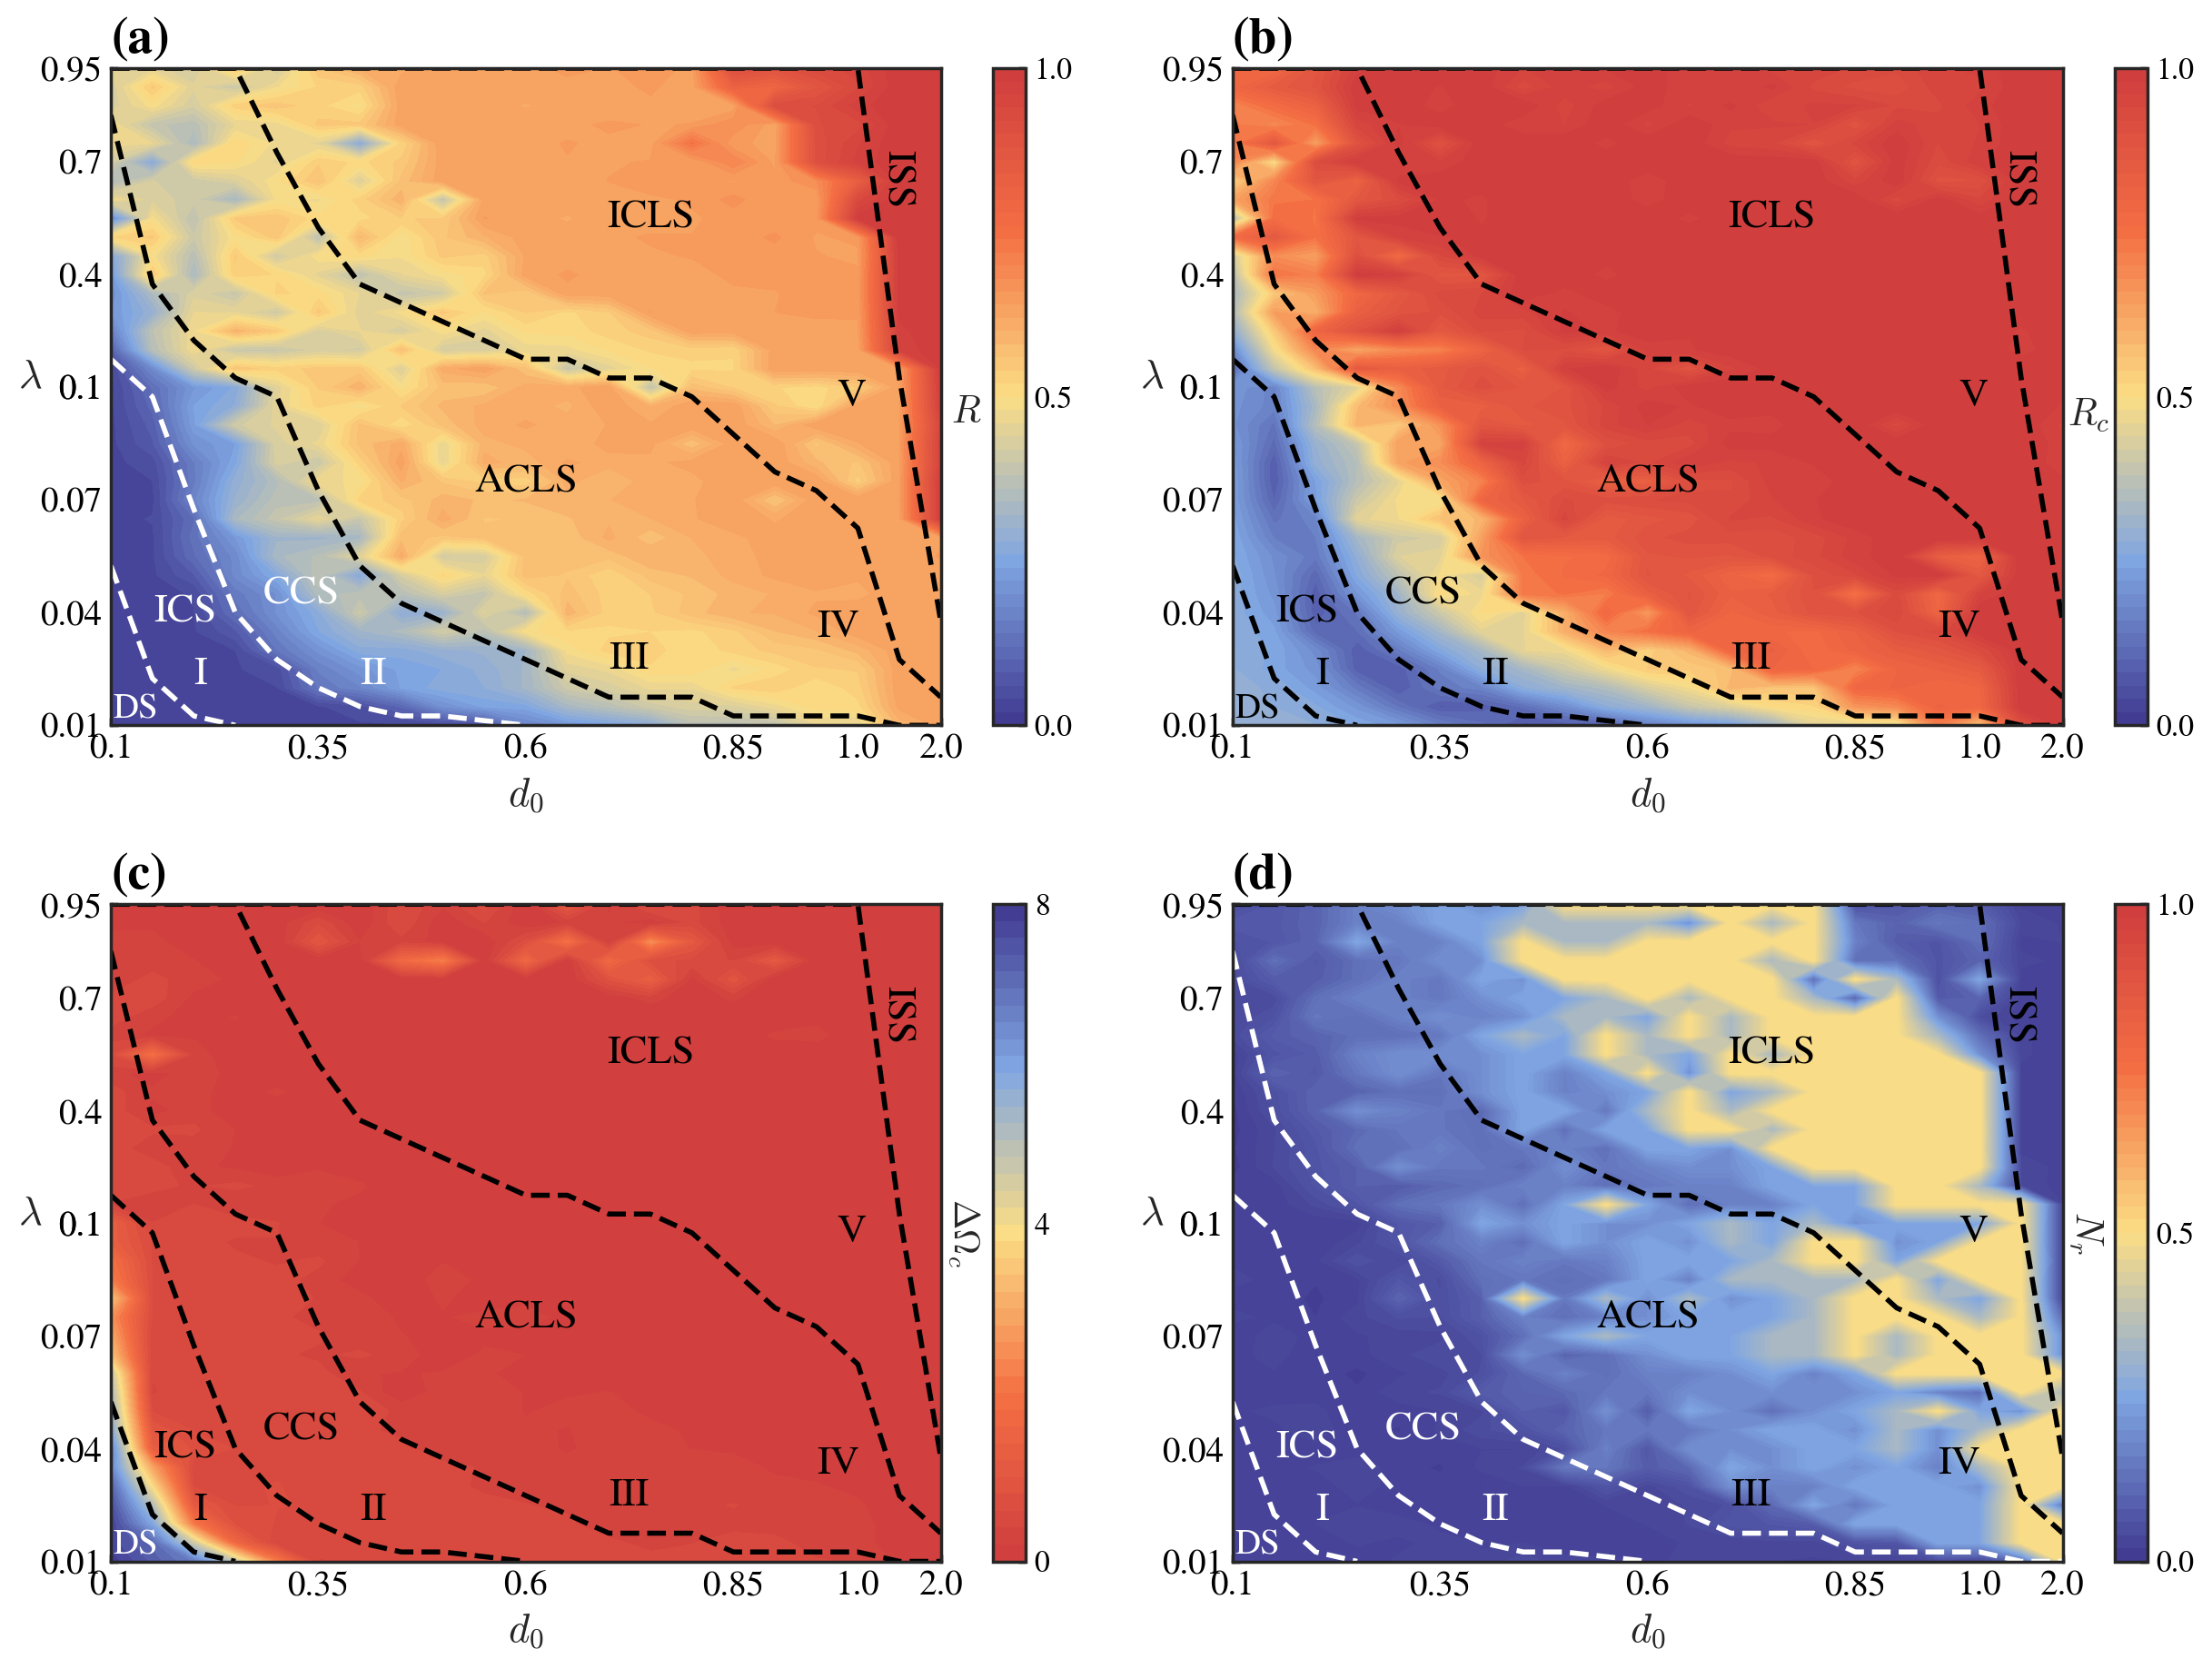

In [13]:
sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

maps1 = pd.read_csv("mean_R_step10.csv", index_col=0)  # clusterDeltaOmega2, deltaOmega1
maps1.index = maps1.index.astype(float)
maps1.columns = maps1.columns.astype(float)

maps2 = pd.read_csv("mean_Rc_step10.csv", index_col=0)
maps2.index = maps2.index.astype(float)
maps2.columns = maps2.columns.astype(float)

maps3 = pd.read_csv("clusterDeltaOmega2.csv", index_col=0)  # clusterDeltaOmega2, deltaOmega1
maps3.index = maps3.index.astype(float)
maps3.columns = maps3.columns.astype(float)

fig, ax = plt.subplots(2, 2, figsize=(16 / 3 * 2.4, 4.7 * 2))
ax = ax.flatten()
colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

level = 50

stdMaps1 = maps1.copy()
stdMaps1.iloc[0, 0] = 0
cf1 = ax[0].contourf(
    stdMaps1, levels=level, vmin=0, vmax=1,
    cmap=cmap,
)
ax[0].contourf(
    maps1, levels=level, vmin=0, vmax=1,
    cmap=cmap,
)
cbar1 = plt.colorbar(cf1, ax=ax[0], ticks=[0, 0.5, 1])
cbar1.set_label(r"$R$", fontsize=15, rotation=0, labelpad=-42)
stdMaps2 = maps2.copy()

stdMaps2.iloc[0, 0] = 0
cf2 = ax[1].contourf(
    stdMaps2, levels=level, vmin=0, vmax=1,
    cmap=cmap,
)
ax[1].contourf(
    maps2, levels=level, vmin=0, vmax=1,
    cmap=cmap,
)
cbar2 = plt.colorbar(cf2, ax=ax[1], ticks=[0, 0.5, 1])
cbar2.ax.set_yticklabels(['0.0', '0.5', '1.0'])
cbar2.set_label(r"$R_c$", fontsize=15, rotation=0, labelpad=-42)

cf3 = ax[2].contourf(
    maps3, levels=level, 
    cmap=cmap_r,
)
cbar3 = plt.colorbar(cf3, ax=ax[2], ticks=[0, 4, 7.8])
cbar3.ax.set_yticklabels(['0', '4', '8'])
cbar3.set_label(r"$\Delta\Omega_c$", fontsize=14, rotation=-90, labelpad=-27)

stdMaps4 = maps4.copy()
stdMaps4.iloc[0, 0] = 1
cf4 = ax[3].contourf(
    stdMaps4, levels=level, vmin=0, vmax=1,
    cmap=cmap,
)
ax[3].contourf(
    maps4, levels=level, vmin=0, vmax=1,
    cmap=cmap,
)
cbar4 = plt.colorbar(cf4, ax=ax[3], ticks=[0, 0.5, 1])
cbar4.ax.set_yticklabels(['0.0', '0.5', '1.0'])
cbar4.set_label(r"$N_{r}$", fontsize=15, rotation=-90, labelpad=-36)

xIdxs = np.arange(len(distanceDs), step=5)
xIdxs = np.insert(xIdxs, -1, 18)
yIdxs = np.concatenate([np.arange(19, step=6), 18 + np.arange(18, step=6)[1:], [35]])
idx = np.where(rangeLambdas == 0.1)[0][0]
yIdxs = np.insert(yIdxs, 4, idx)

selectedColors = ["white", "black", "black", "white"]
selectedColors1 = ["black", "black", "black", "white"]
selectedColors2 = ["white", "black", "white", "white"]
for i in range(4):
    ax[i].tick_params(direction='in', length=3)
    ax[i].set_xticklabels(ax[i].get_xticks(), fontsize=14)
    ax[i].set_yticklabels(ax[i].get_yticks(), fontsize=14)
    ax[i].set_xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
    ax[i].set_yticks(yIdxs, np.round(rangeLambdas, 2)[yIdxs])
    ax[i].set_xlabel(r"$d_0$", fontsize=16)
    ax[i].set_ylabel(r"$\lambda$", rotation=0, fontsize=16)
    ax[i].set_title(f"({chr(97 + i)})", loc="left", fontweight='bold', fontsize=20)
    ax[i].plot(line0[:11],
            linestyle="--", color=selectedColors[i], lw=2, zorder = 2)
    ax[i].plot(funcIdxs[lambda_c1][:4],
            linestyle="--", color=selectedColors[i], lw=2, zorder = 2)
    ax[i].plot(np.arange(maps.shape[1]), funcIdxs[lambda_c2], label=r"$\lambda_{c2}(d_0)$",
            linestyle="--", color=selectedColors1[i], lw=2, zorder = 2)
    ax[i].plot(np.arange(maps.shape[1]), funcIdxs[lambda_c3], label=r"$\lambda_{c3}(d_0)$",
            linestyle="--", color="black", lw=2, zorder = 2)
    ax[i].plot(np.arange(maps.shape[1]), funcIdxs[lambda_c4], label=r"$\lambda_{c4}(d_0)$",
            linestyle="--", color="black", lw=2, zorder = 2)
    ax[i].text(0.05, 0.4, "DS", fontsize=14, color=selectedColors2[i])
    ax[i].text(1.8, 6, "ICS", ha="center", va="center", fontsize=16, color=selectedColors[i])
    ax[i].text(4.6, 7, "CCS", ha="center", va="center", fontsize=16, color=selectedColors[i])
    ax[i].text(10, 13, "ACLS", ha="center", va="center", fontsize=16, color="black")
    ax[i].text(13, 27, "ICLS", ha="center", va="center", fontsize=16, color="black")
    ax[i].text(18.5, 28, "ISS", fontsize=16, color="Black", rotation=-90)
    ax[i].text(2, 2.2, "I", fontsize=16, color=selectedColors[i])
    ax[i].text(6, 2.2, "II", fontsize=16, color=selectedColors[i])
    ax[i].text(12, 3, "III", fontsize=16, color="black")
    ax[i].text(17, 4.7, "IV", fontsize=16, color="black")
    ax[i].text(17.5, 17, "V", fontsize=16, color="black")
    # ax[i].plot([2, 1], [-3, 0], clip_on=False, color="black", lw=1)
    ax[i].set_xlim(0, 20)
    ax[i].set_ylim(0, 35)

for cbar in [cbar1, cbar2, cbar3, cbar4]:
    cbar.ax.tick_params(direction='in', length=3)

plt.tight_layout()
# folderPath = "./PJT_C_Fig"
folderPath = "../../c-doc/[PJT_C] Chiral2/figs"
plt.savefig(f"{folderPath}/orderParam.png", bbox_inches="tight", dpi=300)

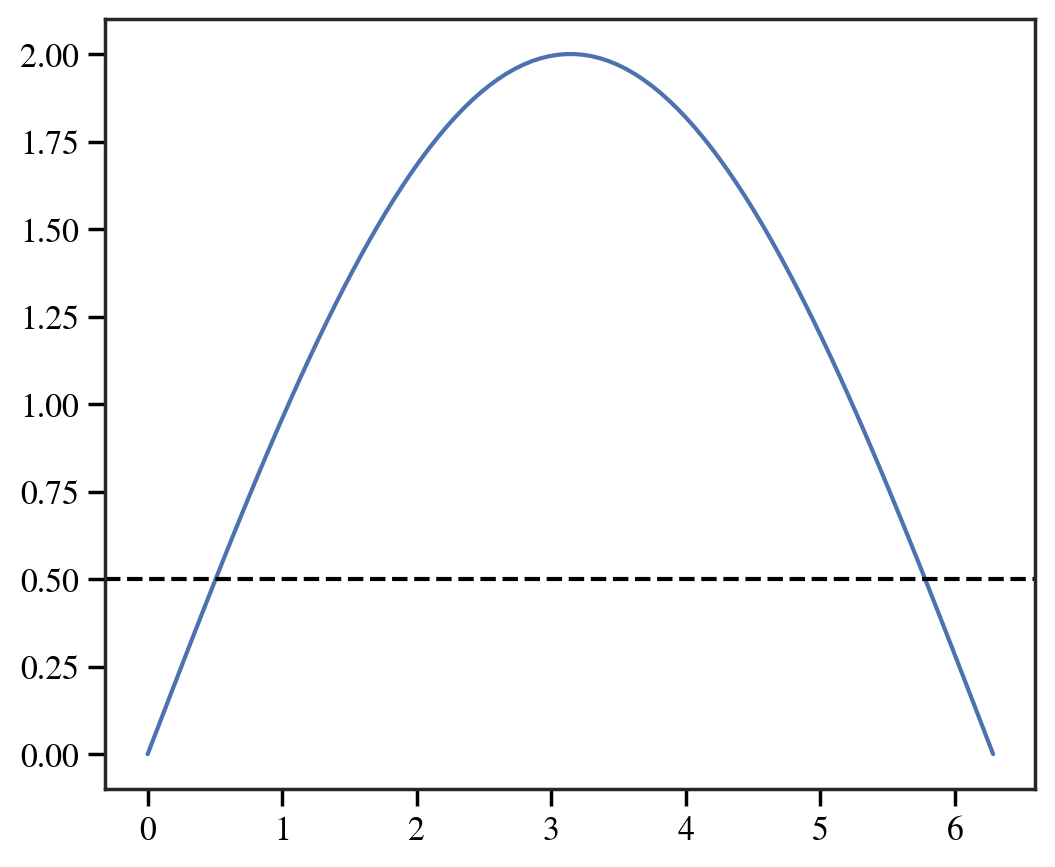

In [134]:
a = np.linspace(0, np.pi * 2, 100)
plt.plot(a, np.sqrt(
    np.sin(a) ** 2 + (1 - np.cos(a)) ** 2
))
plt.axhline(0.5, color="black", linestyle="--")

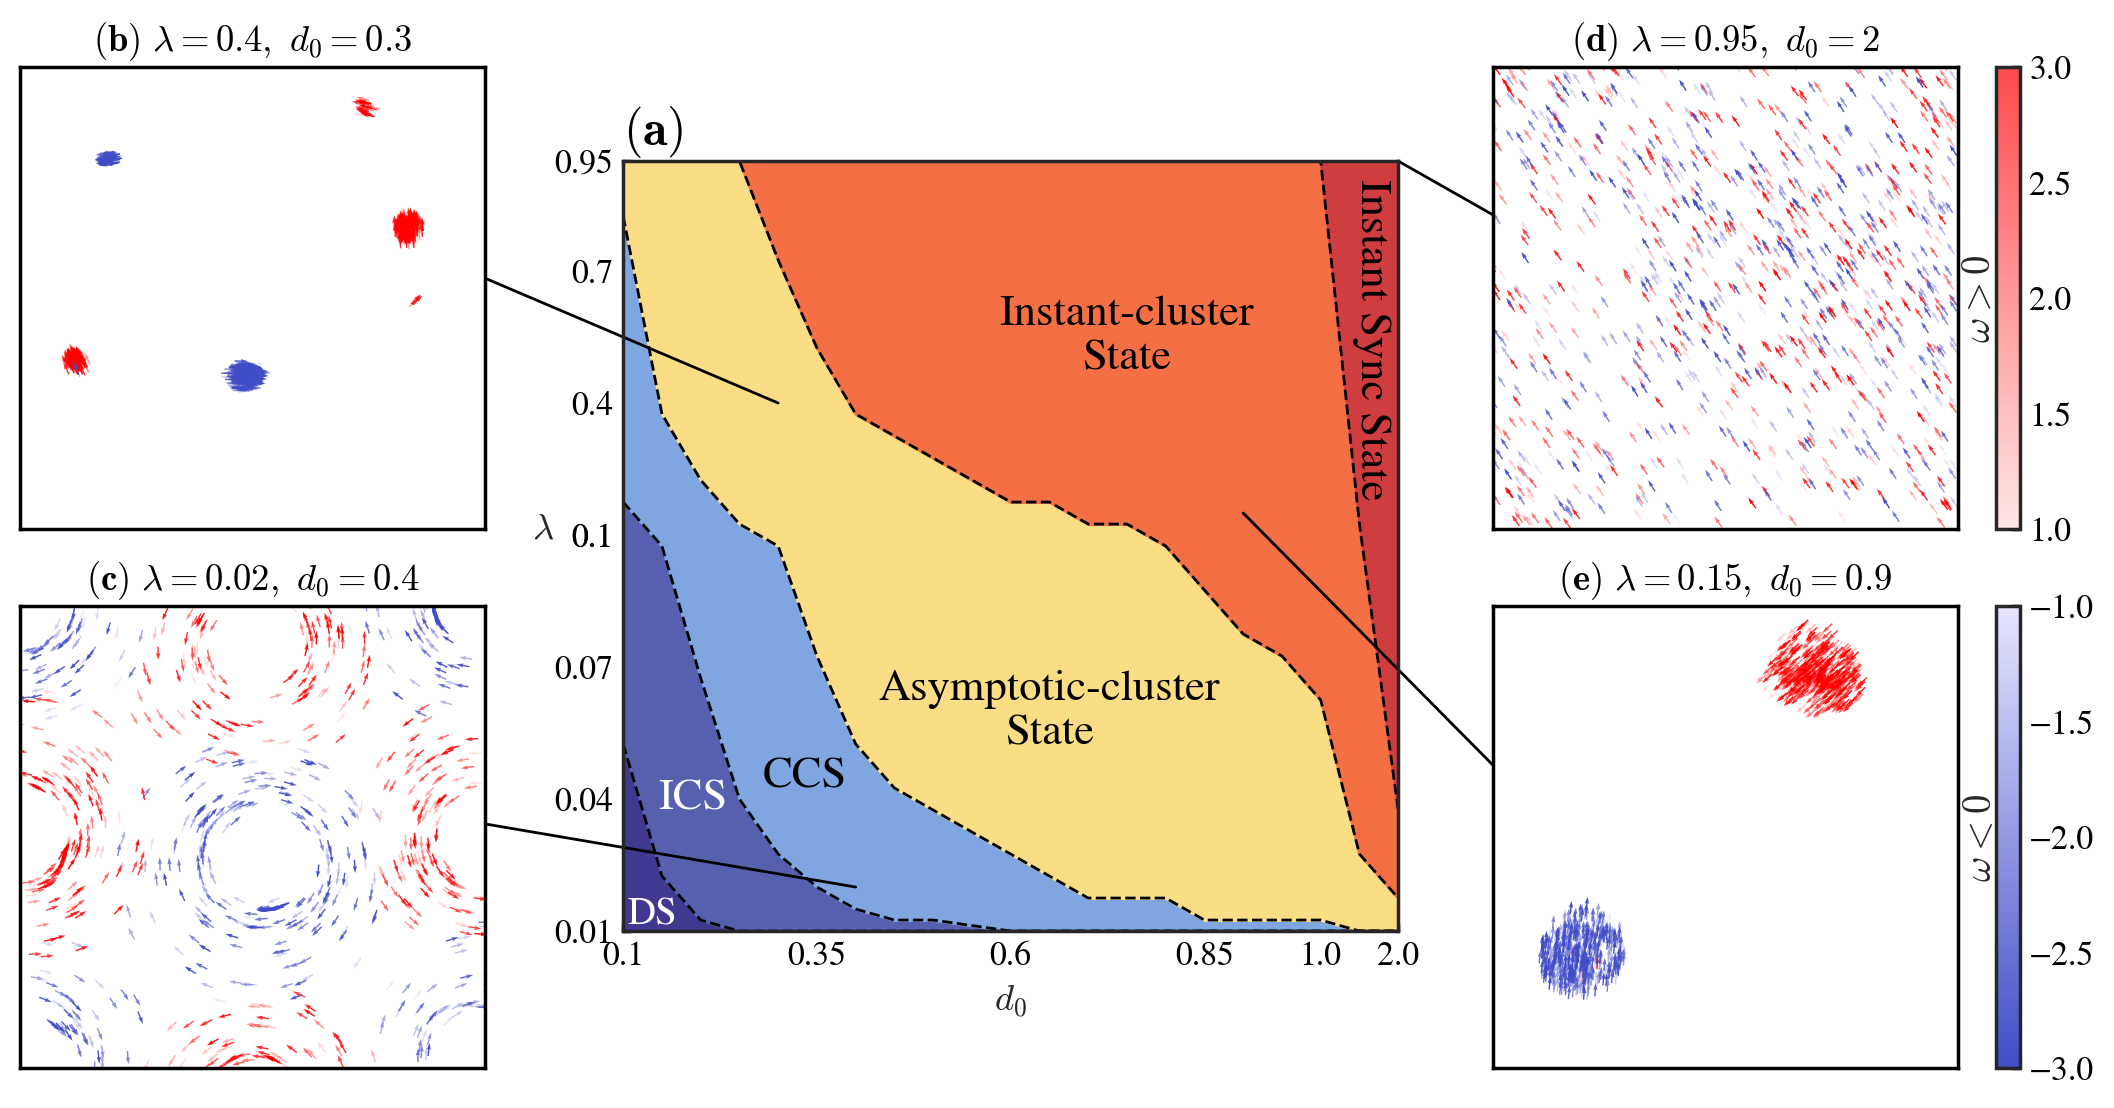

In [14]:
colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.plot(np.arange(maps.shape[1]), funcIdxs[lambda_c1],
         linestyle="--", color="black", lw=1, zorder = 2, label=r"$\lambda_{c1}(d_0)$")
plt.plot(np.arange(maps.shape[1]), line0,
         linestyle="--", color="black", lw=1, zorder = 2, label=r"$\lambda_{c1}(d_0)$")
plt.fill_between(
    np.arange(maps.shape[1]), 0, funcIdxs[lambda_c1], alpha=1, color="#403990"
)
plt.text(0.1, 0.3, "DS", fontsize=14, color="white", rotation=0)
plt.plot(np.arange(maps.shape[1]), funcIdxs[lambda_c2],
         linestyle="--", color="black", lw=1, zorder = 2, label=r"$\lambda_{c1}(d_0)$")
plt.fill_between(
    np.arange(maps.shape[1]), funcIdxs[lambda_c1], line0, alpha=1, color="#5760AE"
)
plt.fill_between(
    np.arange(maps.shape[1]), line0, funcIdxs[lambda_c2], alpha=1, color="#80A6E2"
)
plt.text(1.8, 6, "ICS", ha="center", va="center", fontsize=16, color="white")
plt.text(4.7, 7, "CCS", ha="center", va="center", fontsize=16, color="black")
plt.plot(np.arange(maps.shape[1]), funcIdxs[lambda_c3],
         linestyle="--", color="black", lw=1, zorder = 2, label=r"$\lambda_{c1}(d_0)$")
plt.fill_between(
    np.arange(maps.shape[1]), funcIdxs[lambda_c2], funcIdxs[lambda_c3], alpha=1, color="#FBDD85"
)
plt.text(11, 10, "Asymptotic-cluster\nState", ha="center", va="center", fontsize=16, color="black")
plt.plot(np.arange(maps.shape[1]), funcIdxs[lambda_c4],
         linestyle="--", color="black", lw=1, zorder = 2, label=r"$\lambda_{c1}(d_0)$")
plt.fill_between(
    np.arange(maps.shape[1]), funcIdxs[lambda_c3], funcIdxs[lambda_c4], alpha=1, color="#F46F43"
)
plt.text(13, 27, "Instant-cluster\nState", ha="center", va="center", fontsize=16, color="black")
plt.fill_between(
    np.arange(maps.shape[1]), funcIdxs[lambda_c4], 35, alpha=1, color="#CF3D3E"
)
plt.text(18.8, 20, "Instant Sync State", fontsize=16, color="Black", rotation=-90)
xIdxs = np.arange(len(distanceDs), step=5)
xIdxs = np.insert(xIdxs, -1, 18)
plt.xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
yIdxs = np.concatenate([np.arange(19, step=6), 18 + np.arange(18, step=6)[1:], [35]])
idx = np.where(rangeLambdas == 0.1)[0][0]
yIdxs = np.insert(yIdxs, 4, idx)
plt.yticks(yIdxs, np.round(rangeLambdas, 2)[yIdxs])
plt.tick_params(direction='in', length=3)

plt.xlim(0, 20)
plt.ylim(0, 35)
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$", rotation=0)
plt.grid(False)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

axSwarmM = inset_axes(ax, width="40%", height="40%", loc='lower left',
                      bbox_to_anchor=(-0.8, 0.5, 1.5, 1.5),
                      bbox_transform=ax.transAxes)
ax.plot([-4, 4], [30, 24], clip_on=False, color="black", lw=1)
plot_last_state(f"{0.4:.3f}_{0.3:.2f}", ax=axSwarmM)
axSwarmM.set_title(r"$\mathbf{(b)}\ \lambda=0.4,\ d_0=0.3$")

axRing = inset_axes(ax, width="40%", height="40%", loc='lower left',
                    bbox_to_anchor=(-0.8, -0.2, 1.5, 1.5),
                    bbox_transform=ax.transAxes)
ax.plot([-4, 6], [5, 2], clip_on=False, color="black", lw=1)
plot_last_state(f"{0.02:.3f}_{0.4:.2f}", ax=axRing, loadModel=True, randomSeed=80)
axRing.set_title(r"$\mathbf{(c)}\ \lambda=0.02,\ d_0=0.4$")

axQuickSync = inset_axes(ax, width="40%", height="40%", loc='lower left',
                         bbox_to_anchor=(1.1, 0.5, 1.5, 1.5),
                         bbox_transform=ax.transAxes)
ax.plot([25, 20], [30, 35], clip_on=False, color="black", lw=1)
plot_last_state(f"{0.95:.3f}_{2:.2f}", ax=axQuickSync)
axQuickSync.set_title(r"$\mathbf{(d)}\ \lambda=0.95,\ d_0=2$")

axSwarmD = inset_axes(ax, width="40%", height="40%", loc='lower left',
                      bbox_to_anchor=(1.1, -0.2, 1.5, 1.5),
                      bbox_transform=ax.transAxes)
ax.plot([25, 16], [3, 19], clip_on=False, color="black", lw=1)
plot_last_state(f"{0.15:.3f}_{0.9:.2f}", ax=axSwarmD)
axSwarmD.set_title(r"$\mathbf{(e)}\ \lambda=0.15,\ d_0=0.9$")

colorbarAx1 = inset_axes(ax, width="2%", height="40%", loc='lower left',
                        bbox_to_anchor=(1.75, 0.5, 1.5, 1.5),
                        bbox_transform=ax.transAxes)
alphaRate = 0.9
colors = ["#FFE6E6", "#FF4B4E"]
rcmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
sca = ax.scatter(-np.arange(omegaTheta.size), -np.ones_like(omegaTheta), 
           c=np.linspace(1, 3, len(omegaTheta)), cmap=rcmap)
cbar = plt.colorbar(sca, cax=colorbarAx1)
cbar.set_label(r"$\omega>0$", fontsize=14, labelpad=-39)
cbar.ax.tick_params(direction='in', length=3)

colorbarAx2 = inset_axes(ax, width="2%", height="40%", loc='lower left',
                        bbox_to_anchor=(1.75, -0.2, 1.5, 1.5),
                        bbox_transform=ax.transAxes)
colors = ["#414CC7", "#E6E6FF"]
rcmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
sca = ax.scatter(-np.arange(omegaTheta.size), -np.ones_like(omegaTheta), 
           c=-np.linspace(1, 3, len(omegaTheta)), cmap=rcmap)
cbar = plt.colorbar(sca, cax=colorbarAx2)
cbar.set_label(r"$\omega<0$", fontsize=14, labelpad=-47)
cbar.ax.tick_params(direction='in', length=3)

ax.set_title(r"$\mathbf{(a)}$", loc="left", fontsize=18)

# folderPath = "./PJT_C_Fig"
folderPath = "../../c-doc/[PJT_C] Chiral2/figs"
plt.savefig(f"{folderPath}/phaseDiagram.pdf", bbox_inches="tight", dpi=300)

In [14]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.9, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=80, overWrite=False),
]

d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator


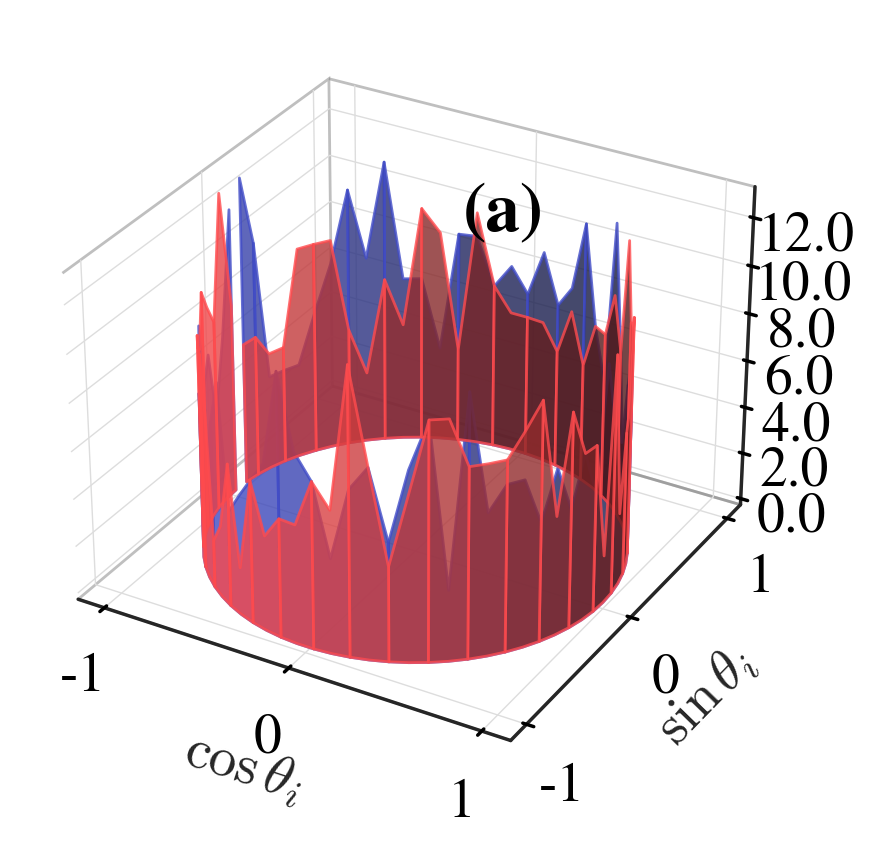

In [11]:
def plot_phase_unit(key: str, ax: plt.Axes, title: str = None, fontsize: int = 20):
    if ax is None:
        ax = plt.figure(figsize=(5, 5)).add_subplot(111, projection='3d')
    lastPhaseTheta = phaseTheta[key]
    hist1, bins = np.histogram(lastPhaseTheta[class1], bins=70, range=(-np.pi, np.pi))
    # print(np.array([np.zeros_like(hist), hist]).shape)
    ax.plot_surface(
        np.cos(bins[:-1]), np.sin(bins[:-1]), 
        np.array([np.zeros_like(hist1), hist1]), 
        color='#FF4B4E', alpha=0.8, edgecolor="#FF4B4E"
    )
    hist2, bins = np.histogram(lastPhaseTheta[class2], bins=70, range=(-np.pi, np.pi))
    ax.plot_surface(
        np.cos(bins[:-1]), np.sin(bins[:-1]),
        np.array([np.zeros_like(hist2), hist2]), 
        color='#414CC7', alpha=0.8, edgecolor="#414CC7"
    )
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])
    ax.set_xlabel(r"$\cos\theta_i$", fontsize=fontsize)
    ax.set_ylabel(r"$\sin\theta_i$", fontsize=fontsize)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('gray')
    ax.yaxis.pane.set_edgecolor('gray')
    ax.zaxis.pane.set_edgecolor('gray')
    # 设置ticks的字体大小
    ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticks(), fontsize=fontsize)
    ax.set_zticklabels(ax.get_zticks(), fontsize=fontsize)
    if title is not None:    
        ax.text(1, -1, max(max(hist1), max(hist2)) * 1.5, title, ha="center", va="center", fontsize=25, fontweight='bold')


plot_phase_unit(f"{0.01:.3f}_{0.1:.2f}", None, title="(a)")

d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  


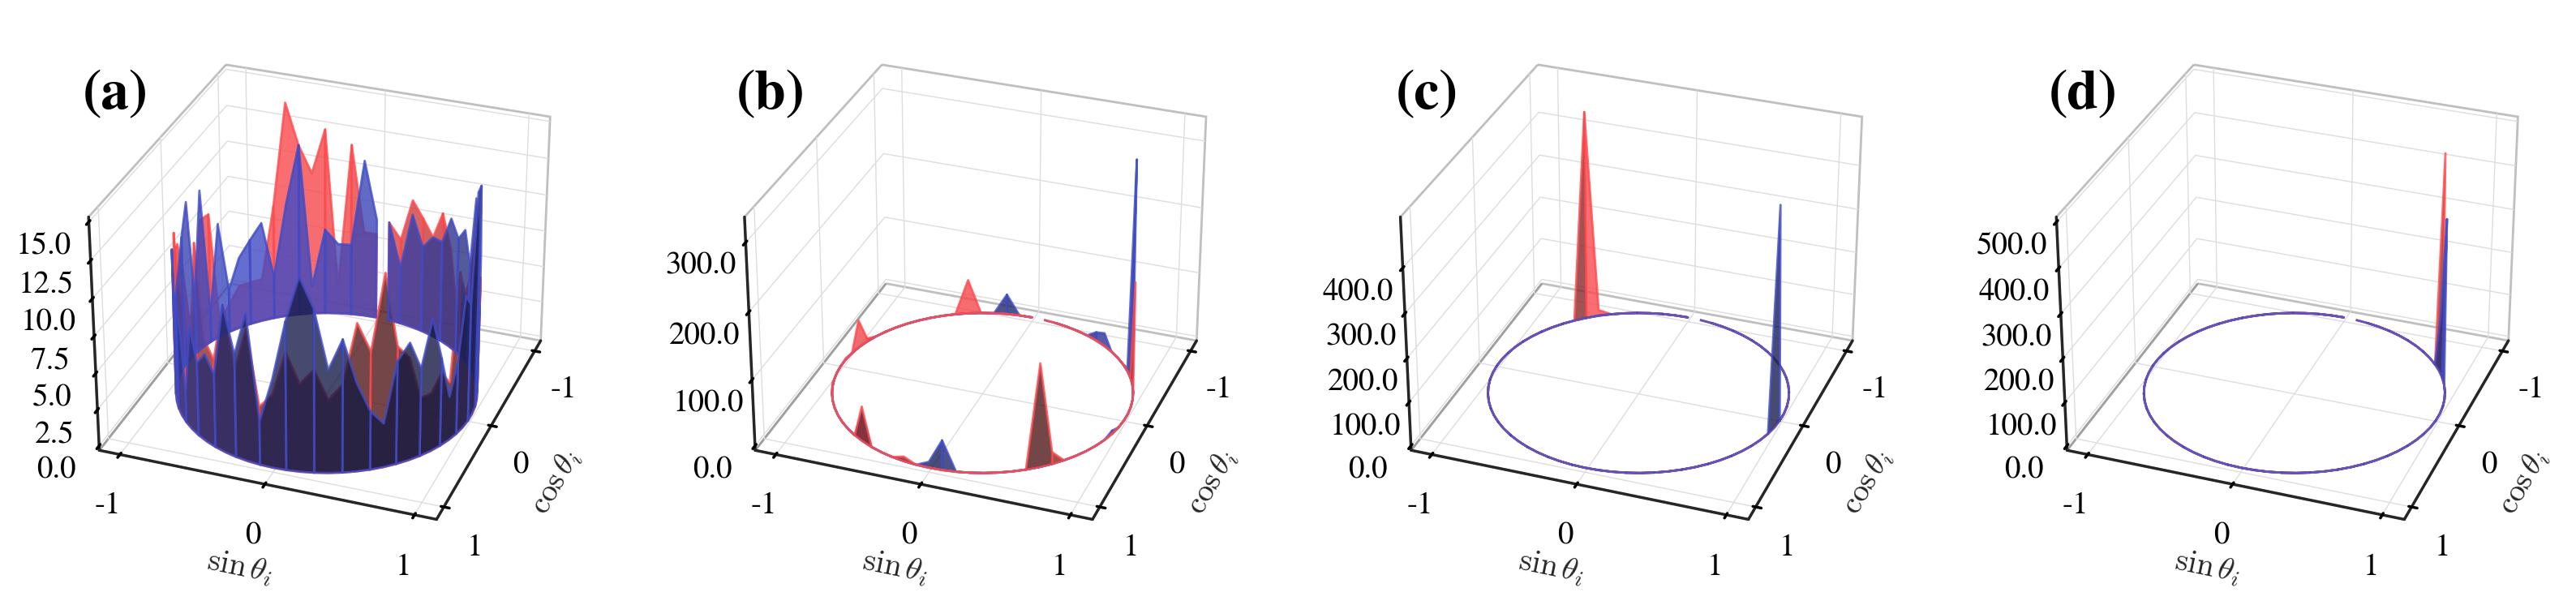

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': '3d'})

keys = [
    f"{0.015:.3f}_{0.35:.2f}",
    f"{0.8:.3f}_{0.2:.2f}",
    f"{0.15:.3f}_{0.9:.2f}",
    f"{0.95:.3f}_{2:.2f}",
]

for i, key in enumerate(keys):
    plot_phase_unit(key, ax[i], title=f"({chr(97 + i)})", fontsize=14)
    # 缩短title与图的距离

plt.tight_layout()
for i in range(4):
    ax[i].view_init(30, 20)

plt.savefig("./PJT_C_Fig/phaseHist.png", bbox_inches="tight", dpi=300)

In [ ]:
def filter_double_cluster(colume: pd.Series):
    colume = colume.copy()
    d0 = colume.name
    critical2 = maps.index[maps.index > lambda_c3(d0)].min()
    if np.isnan(critical2) or np.isnan(lower):
        return colume * np.nan
    critical2Idx = maps.index.get_loc(critical2)
    colume.iloc[:critical2Idx] = np.nan
    if d0 >= 1:
        colume = colume * np.nan
    colume.iloc[critical2Idx + 6:] = np.nan
    # colume.iloc[]
    return colume

meanCounts = []
for dis in tqdm(np.arange(0.15, 0.51, 0.05)):

    maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

    for l, d0 in product(rangeLambdas, distanceDs):

        lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
        lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
        lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

        centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
        centers = np.mod(centers, 10)
        classes = StateAnalysis._calc_classes(
            centers, dis, 
            StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
        )

        classes = [c for c in classes if len(c) > 10]
        
        maps.loc[l, d0] = len(classes)
        filteredMaps = maps.apply(filter_double_cluster)
        notNanCount = filteredMaps.count().sum()
    meanCounts.append(filteredMaps.sum().sum() / notNanCount)
    # meanCounts.append(filteredMaps.min().min())

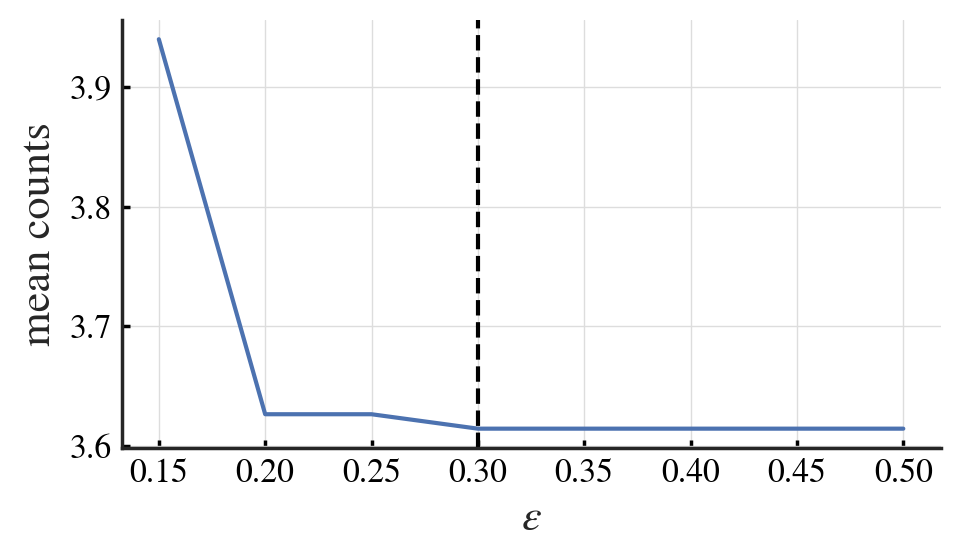

In [129]:
fig = plt.figure(figsize=(5, 3))

plt.plot(np.arange(0.15, 0.51, 0.05), meanCounts)
plt.xticks(np.arange(0.15, 0.51, 0.05))
plt.axvline(x=0.3, color='black', linestyle='--')
plt.xlabel(r"$\varepsilon$", fontsize=16)
plt.ylabel(r"mean counts", fontsize=16)
plt.tick_params(direction='in', length=3)
plt.grid(True)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.tight_layout()
plt.savefig("./PJT_C_Fig/DBSCANparam.pdf", bbox_inches="tight")

In [7]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)
    classes = StateAnalysis._calc_classes(
        centers, 0.3, 
        StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
    )
    
    maps.loc[l, d0] = len(classes)

In [27]:
Aijs = pd.read_parquet(f"./Aij/CorrectCoupling_uniform_{0.02:.3f}_{0.4:.2f}_10_Aij.parquet").values
Aijs = np.reshape(Aijs, (1000, 1000, 1000))

In [75]:
def calc_mean_Aij(model: SpatialGroups):
    sa = StateAnalysis(model)
    totalPositionX = sa.totalPositionX
    totalPointTheta = sa.totalPointTheta
    centers = sa.centers
    classes = StateAnalysis._calc_classes(
        centers, 0.3, 
        StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
    )
    counts = 0
    sumR = 0

    # for classOcsis in classes:
    #     if len(classOcsis) < 5:
    #         continue
        # meanPointTheta = totalPointTheta[-1000:, classOcsis].mean(axis=0) / model.dt
        # sumR += ((meanPointTheta - meanPointTheta[:, np.newaxis])**2).sum() / len(classOcsis) ** 2
        # counts += 1
    tailPosition = totalPositionX[-1000:]
    AijArray = np.array([
    sa.adj_distance(tailPosition[i], tailPosition[i][:, np.newaxis])
        for i in range(tailPosition.shape[0])
    ]) <= model.distanceD0

    df = pd.DataFrame(np.reshape(AijArray, (1000**2, 1000)))
    df.columns = df.columns.astype(str)  
    df.to_parquet(f"Aij/{model}_Aij.parquet")

model = SpatialGroups(strengthLambda=0.02, distanceD0=0.4, dt=0.01, tqdm=False, 
                      savePath="./data", uniform=True, randomSeed=80, overWrite=False)
calc_mean_Aij(model)

In [79]:
model = SpatialGroups(strengthLambda=0.02, distanceD0=0.4, dt=0.01, tqdm=False, 
                      savePath="./data", uniform=True, randomSeed=80, overWrite=False)
bsa = StateAnalysis(model, classDistance=0.3, lookIndex=-1, showTqdm=False)
classes1, centers = bsa.get_classes_centers()
singlePositionX, singlePhaseTheta, _ = bsa.get_state(-1)
idxs = np.concatenate(list(classes1.values()))
# soredPosition = singlePositionX[idxs]
# deltaX = SpatialGroups._delta_x(soredPosition, soredPosition[:, np.newaxis], 10, 5)
# distances = SpatialGroups.distance_x(deltaX)
# Aij1 = distances <= model.distanceD0
key = f"{0.02:.3f}_{0.4:.2f}"
# lastPositionX = positionX[key]
# lastPhaseTheta = phaseTheta[key]
# lastPointTheta = pointTheta[key]
# centers = StateAnalysis._calc_centers(
#     lastPositionX, lastPhaseTheta, lastPointTheta, speedV, 0.01
# )
# centers = np.mod(centers, 10)
# classes = StateAnalysis._calc_classes(
#     centers, 0.3, StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
# )
# classes1 = {i + 1: classes[i] for i in range(len(classes))}
# idxs = np.concatenate(list(classes1.values()))
# deltaX = SpatialGroups._delta_x(soredPosition, soredPosition[:, np.newaxis], 10, 5)
# distances = SpatialGroups.distance_x(deltaX)
Aijs1 = pd.read_parquet(f"./Aij/CorrectCoupling_uniform_{key}_80_Aij.parquet").values
Aijs1 = np.reshape(Aijs1, (1000, 1000, 1000))
Aij1 = Aijs1.mean(axis=0)[idxs, :][:, idxs]
# assert 0

key = f"{0.15:.3f}_{0.9:.2f}"
lastPositionX = positionX[key]
lastPhaseTheta = phaseTheta[key]
lastPointTheta = pointTheta[key]
centers = StateAnalysis._calc_centers(
    lastPositionX, lastPhaseTheta, lastPointTheta, speedV, 0.01
)
classes = StateAnalysis._calc_classes(
    centers, 0.3, StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
)
classes2 = {i + 1: classes[i] for i in range(len(classes))}
idxs = np.concatenate(list(classes2.values()))
soredPosition = lastPositionX[idxs]
deltaX = SpatialGroups._delta_x(soredPosition, soredPosition[:, np.newaxis], 10, 5)
distances = SpatialGroups.distance_x(deltaX)
# Aij2 = distances <= 0.9
Aijs2 = pd.read_parquet(f"./Aij/CorrectCoupling_uniform_{key}_10_Aij.parquet").values
Aijs2 = np.reshape(Aijs2, (1000, 1000, 1000)).transpose(0, 1, 2)
Aij2 = Aijs2.mean(axis=0)[idxs, :][:, idxs]

key = f"{0.4:.3f}_{0.3:.2f}"
lastPositionX = positionX[key]
lastPhaseTheta = phaseTheta[key]
lastPointTheta = pointTheta[key]
centers = lastPositionX
# centers = StateAnalysis._calc_centers(
#     lastPositionX, lastPhaseTheta, lastPointTheta, speedV, 0.01
# )
classes = StateAnalysis._calc_classes(
    centers, 0.3, StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
)
classes3 = {i + 1: classes[i] for i in range(len(classes))}
idxs = np.concatenate(list(classes3.values()))
soredPosition = lastPositionX[idxs]
deltaX = SpatialGroups._delta_x(soredPosition, soredPosition[:, np.newaxis], 10, 5)
distances = SpatialGroups.distance_x(deltaX)
# Aij3 = distances <= 0.3
Aijs3 = pd.read_parquet(f"./Aij/CorrectCoupling_uniform_{key}_10_Aij.parquet").values
Aijs3 = np.reshape(Aijs3, (1000, 1000, 1000))
Aij3 = Aijs3.mean(axis=0)[idxs, :][:, idxs]

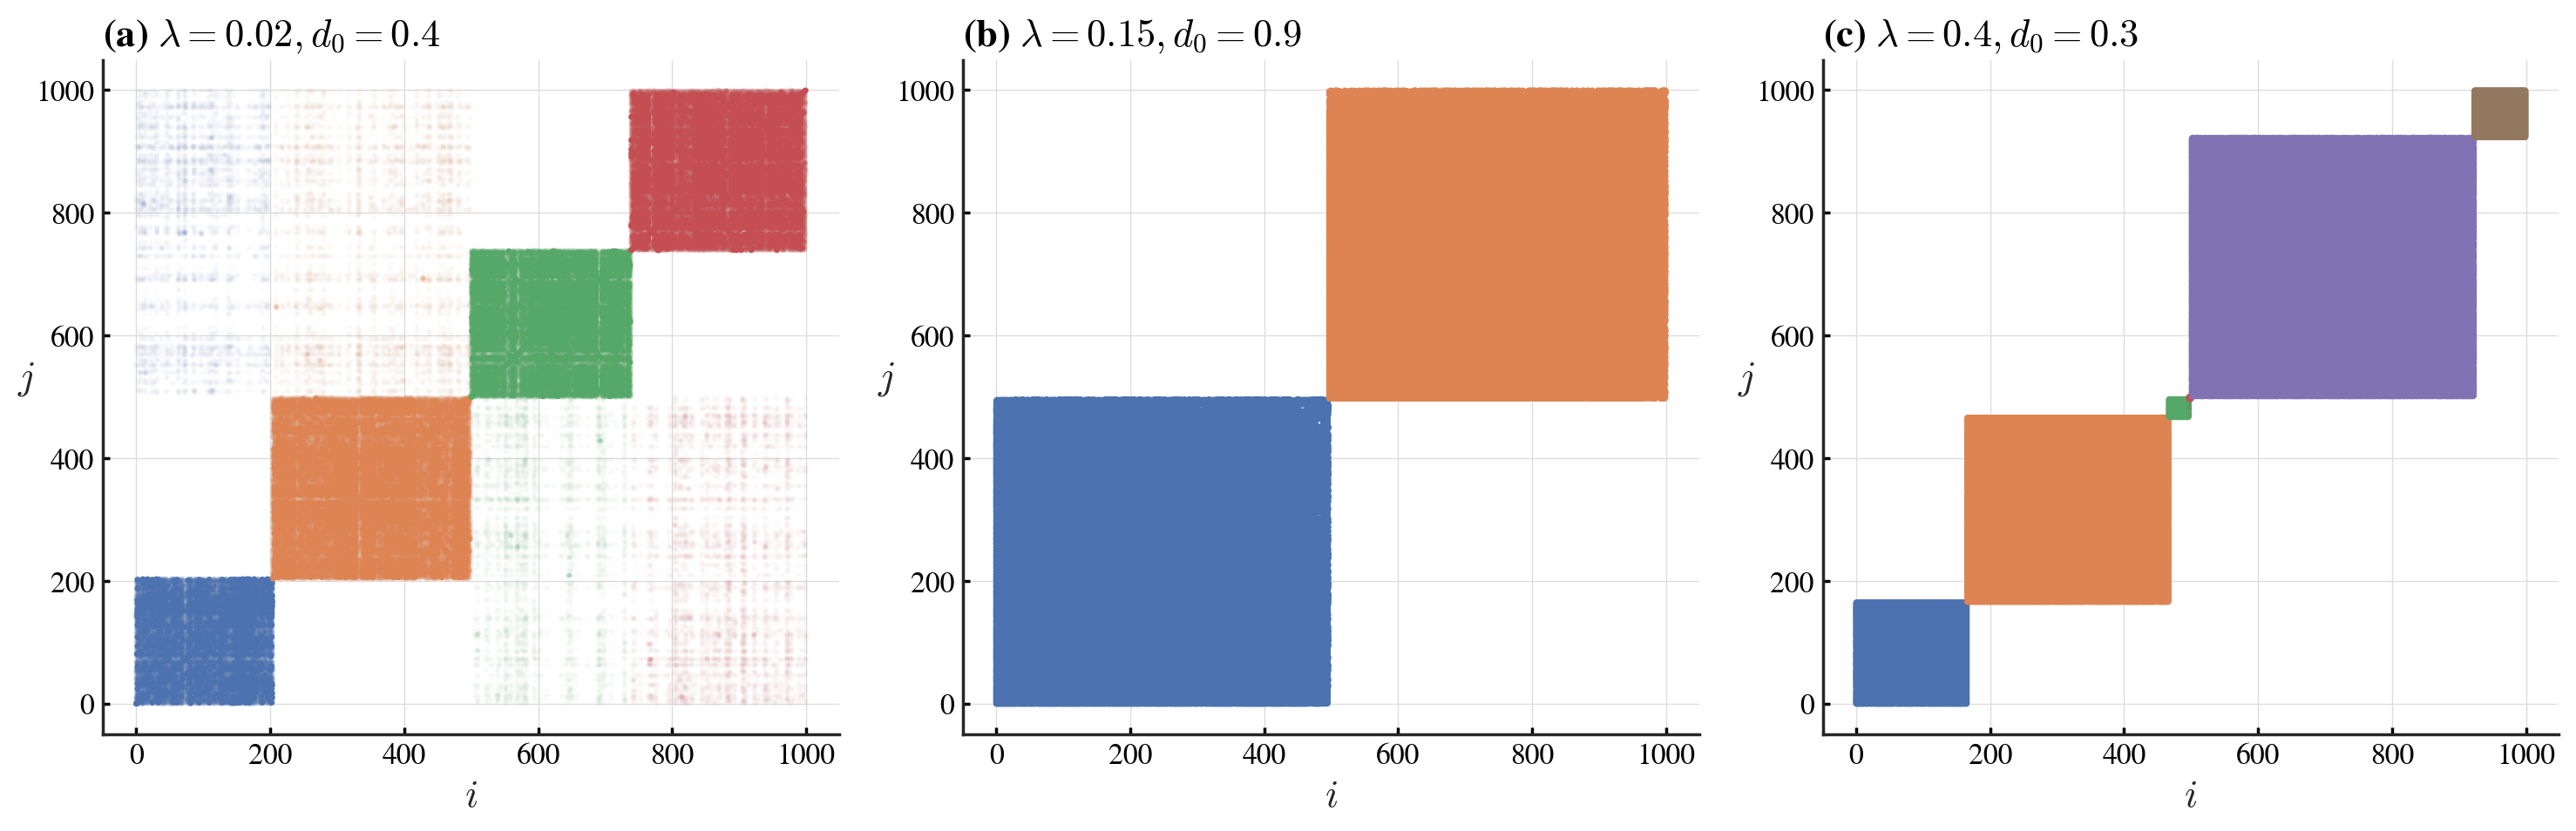

In [81]:
# clusterColors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
clusterColors = ["C0", "C1", "C2", "C3", "C4", "C5", "C6"]
colors1 = np.concatenate([[clusterColors[i - 1]] * len(classes1[i]) for i in range(1, len(classes1) + 1)])
colors2 = np.concatenate([[clusterColors[i - 1]] * len(classes2[i]) for i in range(1, len(classes2) + 1)])
colors3 = np.concatenate([[clusterColors[i - 1]] * len(classes3[i]) for i in range(1, len(classes3) + 1)])

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
ax1, ax2, ax3 = axs

isTrue = np.arange(1000)

for idx, row in enumerate(Aij1):
    # isTrue = np.where(row > 0.7)[0]
    ax1.scatter(np.ones_like(isTrue) * idx, isTrue, color=colors1[idx], s=2, alpha=row)
ax1.set_title(r"(a) $\lambda=0.02, d_0=0.4$", loc="left", fontweight='bold', fontsize=16)

for idx, row in enumerate(Aij2):
    # isTrue = np.where(row > 0.7)[0]
    ax2.scatter(np.ones_like(isTrue) * idx, isTrue, color=colors2[idx], s=2, alpha=row)
ax2.set_title(r"(b) $\lambda=0.15, d_0=0.9$", loc="left", fontweight='bold', fontsize=16)

for idx, row in enumerate(Aij3):
    # isTrue = np.where(row> 0.7)[0]
    ax3.scatter(np.ones_like(isTrue) * idx, isTrue, color=colors3[idx], s=2, alpha=row)
ax3.set_title(r"(c) $\lambda=0.4, d_0=0.3$", loc="left", fontweight='bold', fontsize=16)

for ax in axs:
    ax.tick_params(direction='in', length=3)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_xlabel(r"$i$", fontsize=16)
    ax.set_ylabel(r"$j$", fontsize=16, rotation=0)
    ax.grid(True)

plt.tight_layout()
plt.savefig("./PJT_C_Fig/adjMatrix.png", bbox_inches="tight", dpi=300)

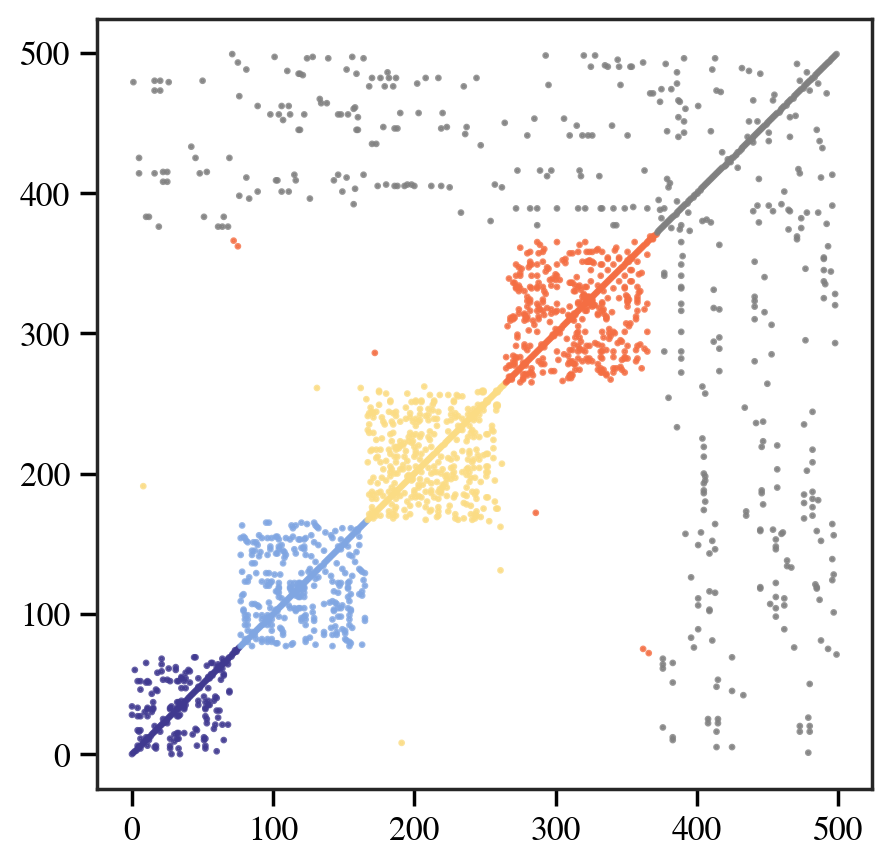

In [93]:
model = SingleDistribution(strengthLambda=0.01, distanceD0=0.35, randomSeed=10, savePath="./data")
plot_Aij(model)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axs.flatten()



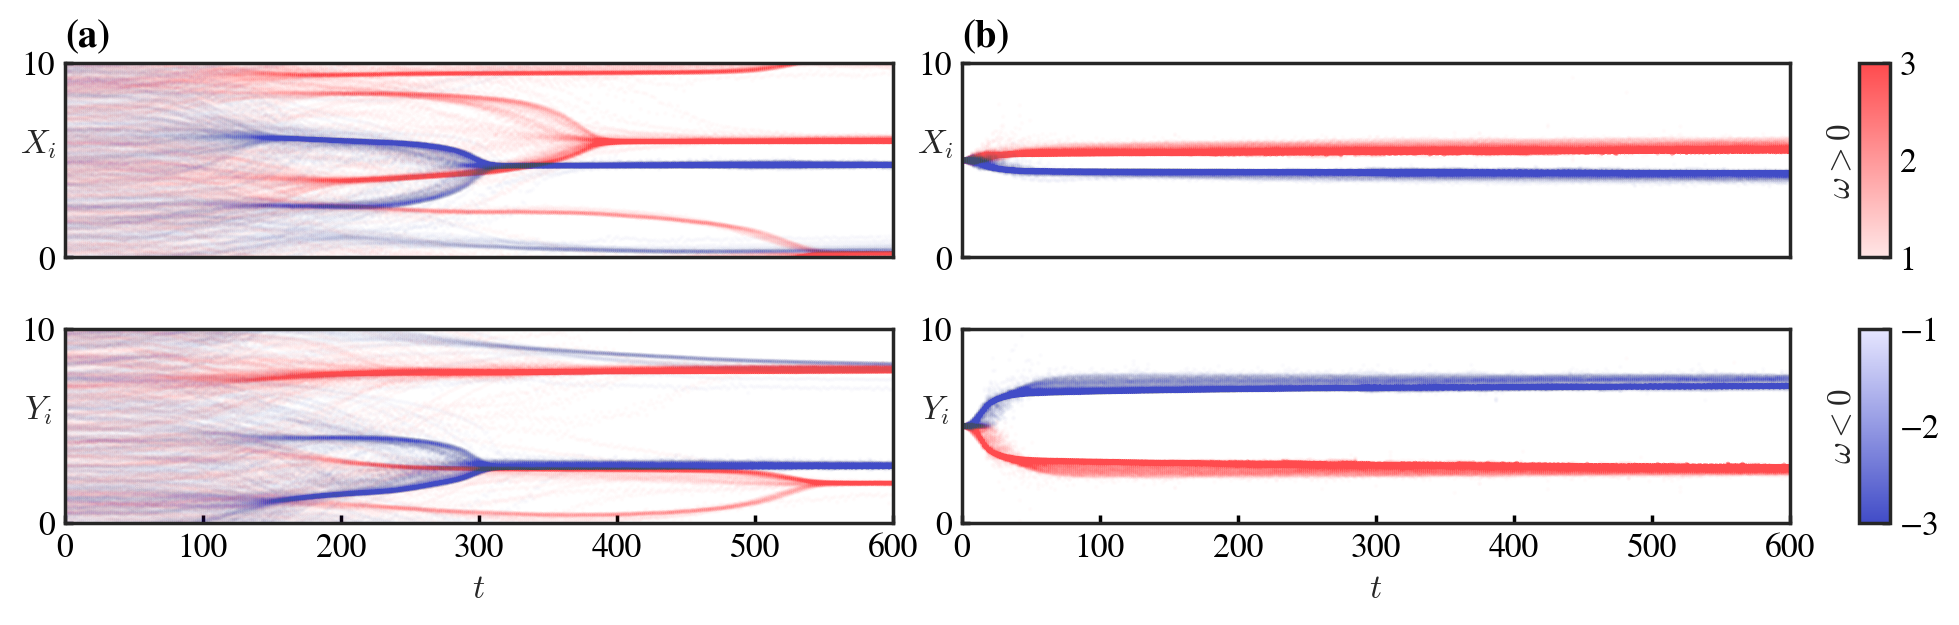

In [13]:
_ = plt.figure(figsize=(10, 5 / 3 * 2))

fontSize = 12

model = SpatialGroups(strengthLambda=0.02, distanceD0=0.4, 
                      savePath="./data", randomSeed=10)
colWide = 18
ax1Row1 = plt.subplot2grid((2, colWide + 1), (0, 0), colspan=colWide // 2)
ax1Row2 = plt.subplot2grid((2, colWide + 1), (1, 0), colspan=colWide // 2)
ax1Row1.tick_params(direction='in', length=3)
ax1Row2.tick_params(direction='in', length=3)
sa = StateAnalysis(model, classDistance=1, lookIndex=-1, showTqdm=False)
cp1, _ = sa.tv_center_position(step=30)
cp1[:, 0] = cp1[:, 0]
color = ["#FF4B4E"] * 500 + ["#414CC7"] * 500
colors = np.array(color * (cp1.shape[0] // 1000))

s = 0.5
alpha = 0.01
step = 2
dt = 0.01
labelpad = -6

np.random.seed(10)
omegaTheta = np.random.uniform(1, 3, size=500)

idx = np.arange(cp1.shape[0], step=step)
ax1Row1.scatter(cp1[idx, 0] * dt * 5, cp1[idx, 1], s=s, alpha=alpha, c=colors[idx])  # 
ax1Row1.set_ylim(0, 10)
ax1Row1.set_xlim(0, 12000 * dt * 5)
ax1Row1.set_xticks([])
ax1Row1.set_ylabel(f"$X_i$", rotation=0, fontsize=fontSize, labelpad=labelpad)
ax1Row1.set_title("(a)", loc="left", fontweight='bold', fontsize=fontSize + 2)
ax1Row1.set_yticks([0, 10])
ax1Row2.scatter(cp1[idx, 0] * dt * 5, cp1[idx, 2], s=s, alpha=alpha, c=colors[idx])  # 
ax1Row2.set_ylim(0, 10)
ax1Row2.set_xlim(0, 12000 * dt * 5)
ax1Row2.set_xlabel(f"$t$", fontsize=fontSize)
ax1Row2.set_ylabel(f"$Y_i$", rotation=0, fontsize=fontSize, labelpad=labelpad)
ax1Row2.set_yticks([0, 10])

model = SpatialGroups(strengthLambda=0.02, distanceD0=0.4, 
                      savePath="./data", randomSeed=20)
ax2Row1 = plt.subplot2grid((2, colWide + 1), (0, colWide // 2), colspan=colWide // 2)
ax2Row2 = plt.subplot2grid((2, colWide + 1), (1, colWide // 2), colspan=colWide // 2)
ax2Row1.tick_params(direction='in', length=3)
ax2Row2.tick_params(direction='in', length=3)
sa = StateAnalysis(model, classDistance=1, lookIndex=-1, showTqdm=False)
cp1, _ = sa.tv_center_position(step=30)

color2 = "#77A4DE"
cp1[:, 0] = cp1[:, 0]

idx = np.arange(cp1.shape[0], step=step)
ax2Row1.scatter(cp1[idx, 0] * dt * 5, cp1[idx, 1], s=s, alpha=alpha, c=colors[idx])  #
ax2Row1.set_ylim(0, 10)
ax2Row1.set_xlim(0, 12000 * dt * 5)
ax2Row1.set_xticks([])
ax2Row1.set_ylabel(f"$X_i$", rotation=0, fontsize=fontSize, labelpad=labelpad)
ax2Row1.set_title("(b)", loc="left", fontweight='bold', fontsize=fontSize + 2)
ax2Row1.set_yticks([0, 10])
sca = ax2Row2.scatter(cp1[idx, 0] * dt * 5, cp1[idx, 2], s=s, alpha=alpha, c=colors[idx])  #
ax2Row2.set_ylim(0, 10)
ax2Row2.set_xlim(0, 12000 * dt * 5)
ax2Row2.set_xlabel(f"$t$", fontsize=fontSize)
ax2Row2.set_ylabel(f"$Y_i$", rotation=0, fontsize=fontSize, labelpad=labelpad)
ax2Row2.set_yticks([0, 10])

colors = ["#FFE6E6", "#FF4B4E"]
labelpad2 = -32
rcmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
sca = ax2Row1.scatter(-np.arange(omegaTheta.size), -np.ones_like(omegaTheta), 
           c=np.linspace(1, 3, len(omegaTheta)), cmap=rcmap)
colorbarAx1 = plt.subplot2grid((2, colWide + 1), (0, colWide))
cbar = plt.colorbar(sca, cax=colorbarAx1)
cbar.set_label(r"$\omega>0$", fontsize=12, labelpad=labelpad2)
cbar.ax.tick_params(direction='in', length=3)

colors = ["#414CC7", "#E6E6FF"]
rcmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
sca = ax2Row2.scatter(-np.arange(omegaTheta.size), -np.ones_like(omegaTheta), 
           c=-np.linspace(1, 3, len(omegaTheta)), cmap=rcmap)
colorbarAx2 = plt.subplot2grid((2, colWide + 1), (1, colWide))
cbar = plt.colorbar(sca, cax=colorbarAx2)
cbar.set_label(r"$\omega<0$", fontsize=12, labelpad=labelpad2 - 8)
cbar.ax.tick_params(direction='in', length=3)

plt.tight_layout(w_pad=0)
plt.savefig("./PJT_C_Fig/centersPosition.png", bbox_inches="tight", dpi=300)

In [4]:
model = SpatialGroups(strengthLambda=0.02, distanceD0=0.4, randomSeed=80, 
                      savePath="./data", uniform=True, overWrite=False)
sa = StateAnalysis(model, classDistance=0.3, lookIndex=-1, showTqdm=False)

In [5]:
meanPointTheta = totalPointTheta[-1000:, :].mean(axis=0) / model.dt

In [6]:
meanPointTheta - meanPointTheta[:, np.newaxis]

array([[ 0.        , -0.53573589,  0.19628164, ..., -2.89821822,
        -3.4600904 , -3.82218128],
       [ 0.53573589,  0.        ,  0.73201753, ..., -2.36248233,
        -2.92435451, -3.28644539],
       [-0.19628164, -0.73201753,  0.        , ..., -3.09449986,
        -3.65637204, -4.01846292],
       ...,
       [ 2.89821822,  2.36248233,  3.09449986, ...,  0.        ,
        -0.56187218, -0.92396306],
       [ 3.4600904 ,  2.92435451,  3.65637204, ...,  0.56187218,
         0.        , -0.36209088],
       [ 3.82218128,  3.28644539,  4.01846292, ...,  0.92396306,
         0.36209088,  0.        ]])

In [15]:
models = [
    CorrectCouplingAfter(
        strengthLambda=0.01, distanceD0=2, enhancedLambdas=np.linspace(0.01, 0.9, 100000),
        savePath="./data", randomSeed=10, tqdm=True, overWrite=True
    ),
    CorrectCouplingAfter(
        strengthLambda=0.9, distanceD0=2, enhancedLambdas=np.linspace(0.9, 0.01, 100000),
        savePath="./data", randomSeed=10, tqdm=True, overWrite=True
    )
]
sas = [
    StateAnalysis(models[0]),
    StateAnalysis(models[1])
]

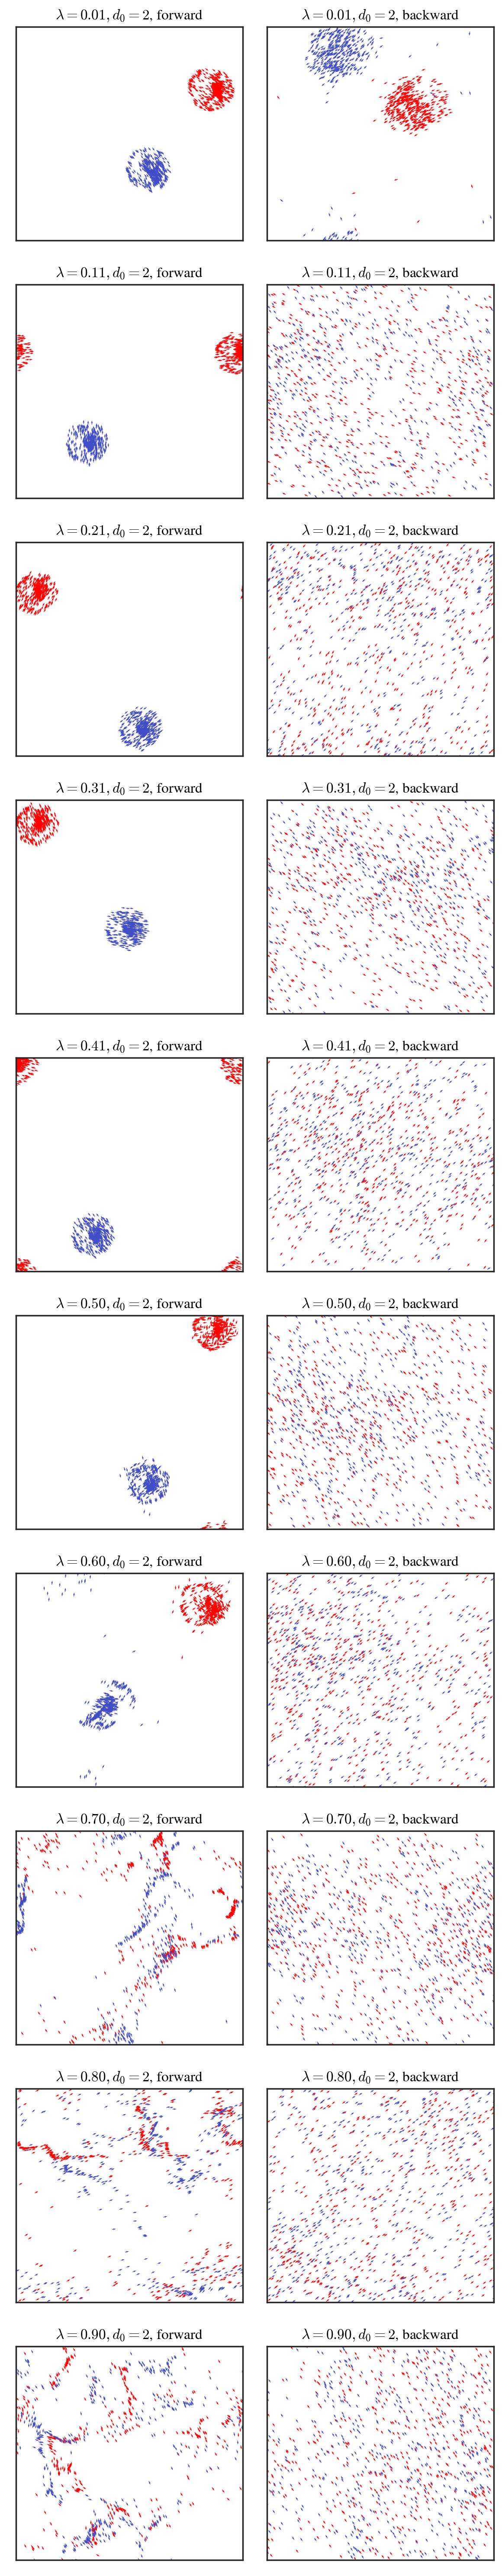

In [16]:
colors = ["red"] * 500 + ["#414CC7"] * 500

rowNum = 10
fig, axs = plt.subplots(rowNum, 2, figsize=(6, rowNum * 3))

for modelIdx in range(2):
    sa = sas[modelIdx]
    lookIdxs = np.linspace(0, sa.TNum - 1, rowNum).round().astype(int)
    for rowIdx in range(rowNum):
        if modelIdx == 0:
            lookIdx = lookIdxs[rowIdx]
            direction = "forward"
        else:
            lookIdx = lookIdxs[::-1][rowIdx]
            direction = "backward"
        ax = axs[rowIdx, modelIdx]
        sa.plot_spatial(ax, index=lookIdx, color=colors)
        ax.set_xticks([])
        ax.set_yticks([])
        strengthLambda = np.linspace(0.01, 0.9, rowNum)[rowIdx]
        ax.set_title(fr"$\lambda={strengthLambda:.2f}, d_0=2$, {direction}", fontsize=12)

plt.tight_layout()
plt.savefig("./PJT_C_Fig/adiabaticTuningISS.png", bbox_inches="tight", dpi=300)

In [18]:
sa = sas[0]
totalPhaseTheta = sa.totalPhaseTheta
Rseries = np.abs(np.sum(np.exp(1j * totalPhaseTheta), axis=1)) / model.agentsNum
window = 300
forwardRseriesMMax = (
    pd.Series(Rseries, index=np.linspace(0.01, 0.9, Rseries.size))
    .rolling(window=window, center=True, min_periods=1)
    .max()
)
forwardRseriesMMin = (
    pd.Series(Rseries, index=np.linspace(0.01, 0.9, Rseries.size))
    .rolling(window=window, center=True, min_periods=1)
    .min()
)
sa = sas[1]
totalPhaseTheta = sa.totalPhaseTheta
Rseries = np.abs(np.sum(np.exp(1j * totalPhaseTheta), axis=1)) / model.agentsNum
backwardRseriesMMax = (
    pd.Series(Rseries, index=np.linspace(0.9, 0.01, Rseries.size))
    .rolling(window=window, center=True, min_periods=1)
    .max()
)
backwardRseriesMMin = (
    pd.Series(Rseries, index=np.linspace(0.9, 0.01, Rseries.size))
    .rolling(window=window, center=True, min_periods=1)
    .min()
)

$$
R_{\max}\left( t \right) =\max_{\tau \in \left[ t-l,t+l \right]} R\left( \tau \right)
$$
$$
R_{\min}\left( t \right) =\min_{\tau \in \left[ t-l,t+l \right]} R\left( \tau \right)
$$

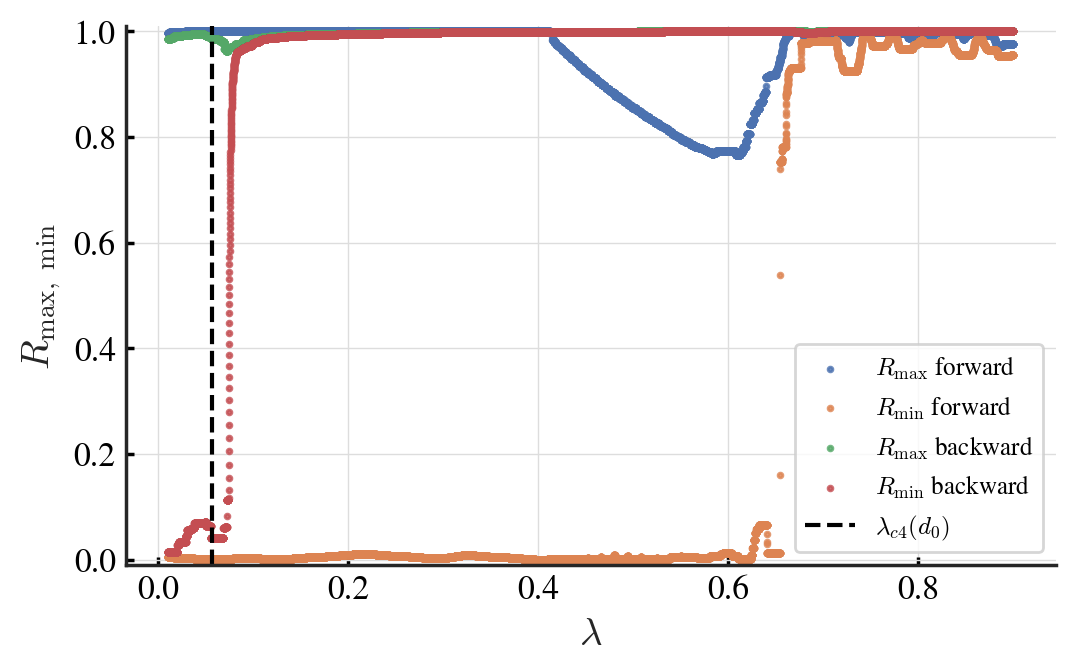

In [19]:
plt.figure(figsize=(6, 3.5))
forwardIndex = forwardRseriesMMax.index
alpha = 1
s = 3
plt.scatter(forwardIndex, forwardRseriesMMax, alpha=0.8, s=s, label=r"$R_{\max}$ forward")
plt.scatter(forwardIndex, forwardRseriesMMin, alpha=0.8, s=s, label=r"$R_{\min}$ forward")
backwardIndex = backwardRseriesMMax.index
plt.scatter(backwardIndex, backwardRseriesMMax, alpha=0.8, s=s, label=r"$R_{\max}$ backward")
plt.scatter(backwardIndex, backwardRseriesMMin, alpha=0.8, s=s, label=r"$R_{\min}$ backward")
plt.axvline(x=lambda_c4(2), color="black", linestyle="--", label=r"$\lambda_{c4}(d_0)$")
plt.ylim(-0.01, 1.01)
plt.tick_params(direction='in', length=3)
plt.xlabel(r"$\lambda$", fontsize=14)
plt.ylabel(r"$R_{\max,\ \min}$", fontsize=14)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.grid(True)
plt.legend(loc="lower right", fontsize=9)
plt.savefig("./PJT_C_Fig/adiabaticTuningOrderParam.png", bbox_inches="tight", dpi=300)

$$
\mathbf{I}=\left( I_{ij} \right) \;,
$$
where
$$
I_{ij}=\lim_{T\rightarrow \infty} \frac{1}{T}\int_0^T{H\left( d_0-\Delta \mathbf{r}_{j,i}\left( t \right) \right) \text{d}t}
$$

Corresponding order parameter:
$$
\mathbf{\bar{I}}=\frac{1}{N^2}\sum_{i,j=1}^N{I_{ij}}
$$


Text(17.5, 17, 'IV')

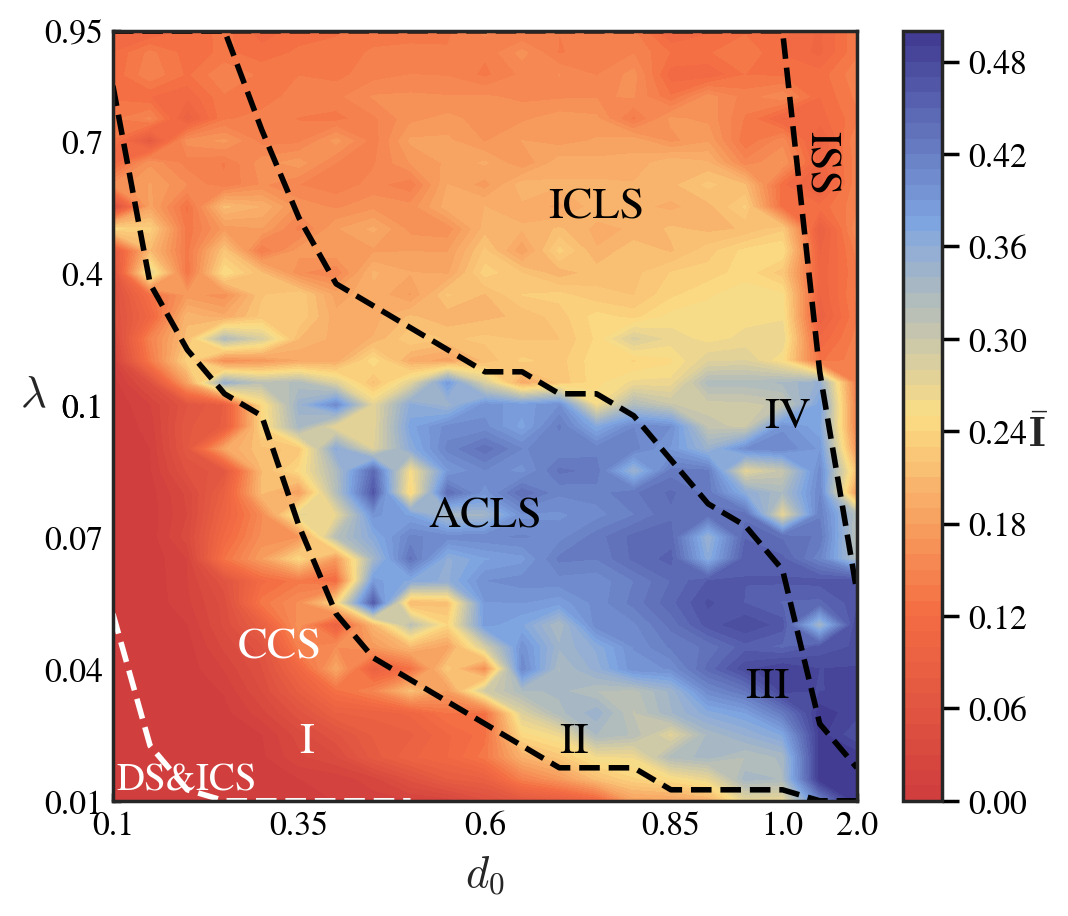

In [114]:
mapsMeanAijMaps = pd.read_csv("mapsMeanAij.csv", index_col=0)
mapsMeanAijMaps.index = mapsMeanAijMaps.index.astype(float)
mapsMeanAijMaps.columns = mapsMeanAijMaps.columns.astype(float)

colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])


cf = plt.contourf(
    mapsMeanAijMaps, levels=50, 
    cmap=cmap_r,
)
cbar3 = plt.colorbar(cf)
cbar3.set_label(r"$\bar{\mathbf{I}}$", fontsize=15, rotation=0)
plt.tick_params(direction='in', length=3)
xIdxs = np.arange(len(distanceDs), step=5)
xIdxs = np.insert(xIdxs, -1, 18)
yIdxs = np.concatenate([np.arange(19, step=6), 18 + np.arange(18, step=6)[1:], [35]])
idx = np.where(rangeLambdas == 0.1)[0][0]
yIdxs = np.insert(yIdxs, 4, idx)
plt.xticks(xIdxs, np.round(distanceDs, 2)[xIdxs])
plt.yticks(yIdxs, np.round(rangeLambdas, 2)[yIdxs])
plt.xlabel(r"$d_0$", fontsize=16)
plt.ylabel(r"$\lambda$", rotation=0, fontsize=16)
selectedColors = ["white", "black", "black"]
i = 0
plt.plot(funcIdxs[lambda_c1][:9],
            linestyle="--", color=selectedColors[i], lw=2, zorder = 2)
# plt.plot(np.arange(maps.shape[1]), funcIdxs[lambda_c2], label=r"$\lambda_{c2}(d_0)$",
#             linestyle="--", color="black", lw=2, zorder = 2)
plt.plot(np.arange(maps.shape[1]), funcIdxs[lambda_c3], label=r"$\lambda_{c3}(d_0)$",
        linestyle="--", color="black", lw=2, zorder = 2)
plt.plot(np.arange(maps.shape[1]), funcIdxs[lambda_c4], label=r"$\lambda_{c4}(d_0)$",
        linestyle="--", color="black", lw=2, zorder = 2)
plt.plot(np.arange(maps.shape[1]), funcIdxs[lambda_c5], label=r"$\lambda_{c4}(d_0)$",
        linestyle="--", color="black", lw=2, zorder = 2)
# ax[i].text(0, -4, "Disorder State", fontsize=16, color="black", rotation=0)

plt.text(0.1, 0.5, "DS&ICS", fontsize=14, color=selectedColors[i])
plt.text(4.5, 7, "CCS", ha="center", va="center", fontsize=16, color=selectedColors[i])
plt.text(10, 13, "ACLS", ha="center", va="center", fontsize=16, color="black")
plt.text(13, 27, "ICLS", ha="center", va="center", fontsize=16, color="black")
plt.text(18.5, 28, "ISS", fontsize=16, color="Black", rotation=-90)
plt.text(5, 2.2, "I", fontsize=16, color=selectedColors[i])
plt.text(12, 2.2, "II", fontsize=16, color="black")
plt.text(17, 4.7, "III", fontsize=16, color="black")
plt.text(17.5, 17, "IV", fontsize=16, color="black")

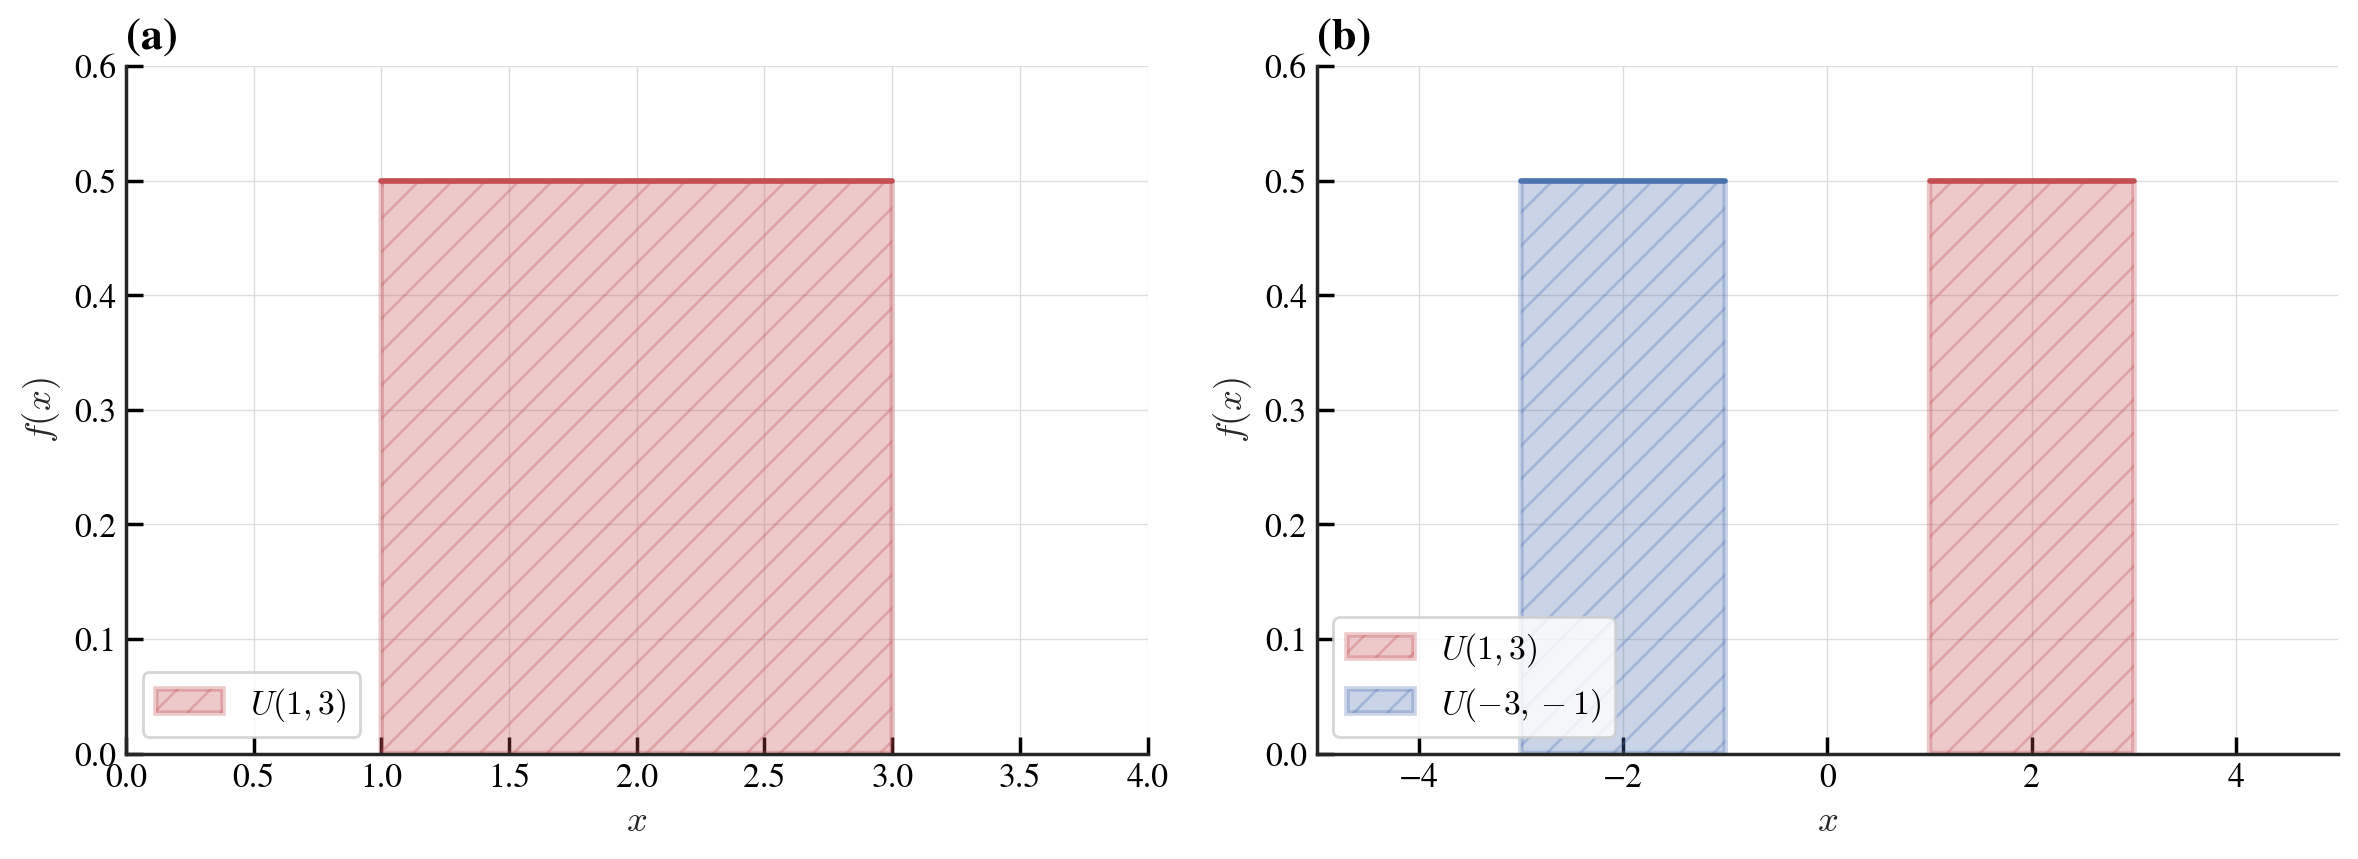

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

ax1, ax2 = axs

a0, b0 = 1, 3
x0 = np.linspace(a0, b0, 1000)
ax1.plot(x0, np.ones_like(x0) * (1 / (b0 - a0)), 'r', linewidth=2)
ax1.fill_between(x0, 0, np.ones_like(x0) * (1 / (b0 - a0)), linewidth=2, color='r', alpha=0.3, hatch='//', label=r"$U(1,3)$")

ax1.set_xlim(0, 4)
ax1.set_ylim(0, 0.6)
ax1.grid(True)
ax1.legend(loc='lower left')
ax1.set_title("(a)", loc='left', fontweight='bold', fontsize=16)

a1, b1 = 1, 3
x1 = np.linspace(a1, b1, 1000)
ax2.plot(x1, np.ones_like(x1) * (1 / (b1 - a1)), 'r', linewidth=2)
ax2.fill_between(x1, 0, np.ones_like(x1) * (1 / (b1 - a1)), linewidth=2, color='r', alpha=0.3, hatch='//', label=r"$U(1,3)$")

a2, b2 = -3, -1
x2 = np.linspace(a2, b2, 1000)
ax2.plot(x2, np.ones_like(x2) * (1 / (b2 - a2)), 'b', linewidth=2)
ax2.fill_between(x2, 0, np.ones_like(x2) * (1 / (b2 - a2)), linewidth=2, color='b', alpha=0.3, hatch='//', label=r"$U(-3,-1)$")

ax2.set_xlim(-5, 5)
ax2.set_ylim(0, 0.6)
ax2.grid(True)
ax2.legend()
ax2.set_title("(b)", loc='left', fontweight='bold', fontsize=16)

for ax in axs:
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$f(x)$")
    ax.tick_params(direction='in')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')

plt.tight_layout()
# plt.show()
plt.savefig("./normalMP4/Fig1_freq_distri.png", dpi=200, bbox_inches='tight')